# Investigate behaviour of 1D system

In [2]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LogNorm
from scipy.signal import find_peaks, correlate
from IPython.display import HTML
from tqdm import tqdm
import pickle
import matplotlib.cm as cm
import visualisation as vis
from delta_hes_model import *


## Functions

In [3]:
def test_Delta_coup(coefficient, coup_strength, hill_coeff, lattice, params, num_tsteps, dt):
    print('Coefficient:', coefficient)
    print('Coupling strength:', coup_strength)

    params.n = coefficient
    params.w_coupling = coup_strength

    h, m_h, d, m_d = simulate(num_tsteps, dt, lattice, params, hill_coeff, coupling_type= 'Delta', initial_type='checkerboard')

    return h, m_h, d, m_d

def smoothen_signal(signal, window_size=5):
    """
    Smoothen a 1D signal using a moving average filter.

    Parameters:
    - signal: 1D numpy array of the signal values
    - window_size: Size of the moving window (default is 5)

    Returns:
    - smoothed_signal: Smoothed signal (1D numpy array)
    """
    if window_size < 1:
        raise ValueError("Window size must be at least 1.")
    
    # Create the moving average filter
    kernel = np.ones(window_size) / window_size
    smoothed_signal = np.convolve(signal, kernel, mode='same')

    return smoothed_signal

def estimate_period_from_peaks(signal, time=None, height=None, distance=None, prominence=None):
    """
    Estimate the period of an oscillating signal using peak detection.

    Parameters:
    - signal: 1D numpy array of the signal values
    - time: Optional 1D array of time values (same length as signal). If None, assume uniform time steps.
    - height, distance, prominence: Optional arguments passed to find_peaks for filtering.

    Returns:
    - period: Estimated average period (float)
    - peak_times: Time values of the detected peaks
    """
    # Find peaks
    peaks, _ = find_peaks(signal, height=height, distance=distance, prominence=prominence)
    if time is None:
        # Assume uniform spacing
        time = np.arange(len(signal))

    peak_times = time[peaks]

    if len(peak_times) < 4:
        period = -1000  # Not enough peaks to estimate period

    # Calculate differences between consecutive peaks
    peak_diffs = np.diff(peak_times)
    period = np.mean(peak_diffs)

    return period, peak_times

def estimate_period_fft(signal, time=None, detrend=False):
    """
    Estimate the dominant period of a signal using Fourier Transform.

    Parameters:
    - signal: 1D array of signal values
    - time: 1D array of time values (if None, assume uniform time steps)
    - detrend: Remove the mean before FFT to reduce DC offset

    Returns:
    - period: Estimated dominant period
    - freqs: Frequencies used
    - power: Power spectrum
    """
    if time is None:
        dt = 1.0  # assume uniform spacing of 1
        time = np.arange(len(signal))
    else:
        dt = np.mean(np.diff(time))  # average time step

    if detrend:
        signal = signal - np.mean(signal)  # remove DC component

    # Perform FFT
    fft_vals = np.fft.fft(signal)
    fft_freqs = np.fft.fftfreq(len(signal), d=dt)

    # Use only positive frequencies
    pos_mask = fft_freqs > 0
    freqs = fft_freqs[pos_mask]
    power = np.abs(fft_vals[pos_mask])**2

    # Find the peak frequency
    peak_idx = np.argmax(power)
    dominant_freq = freqs[peak_idx]
    period = 1 / dominant_freq

    return period, freqs, power

def estimate_period_autocorr(signal, time=None, detrend=False, height = None, min_period=1):
    """
    Estimate the dominant period of a signal using autocorrelation.

    Parameters:
    - signal: 1D array of the signal values
    - time: 1D array of time points (optional, required for real period values)
    - detrend: Whether to subtract the mean (removes DC offset)
    - min_period: Minimum time (or index) to consider between peaks

    Returns:
    - estimated_period: Dominant period (in time units if time is provided)
    - lags: Lag values
    - autocorr: Autocorrelation values
    """
    n = len(signal)

    if detrend:
        signal = signal - np.mean(signal)

    # Full autocorrelation, symmetric around center
    autocorr_full = correlate(signal, signal, mode='full')
    autocorr = autocorr_full[n-1:]  # second half only
    autocorr /= autocorr[0]  # normalize

    lags = np.arange(len(autocorr))

    # Find peaks in autocorrelation
    peaks, _ = find_peaks(autocorr, distance=min_period, height=height)

    if len(peaks) < 1:
        return None, lags, autocorr  # No peaks found

    dominant_lag = peaks[0]

    if time is not None:
        dt = np.mean(np.diff(time))
        estimated_period = dominant_lag * dt
    else:
        estimated_period = dominant_lag  # in sample units

    return estimated_period, lags, autocorr

def estimate_amplitude_from_peaks(signal, height=None, distance=None, prominence=None):
    """
    Estimate amplitude by detecting peaks and computing average peak height.

    Parameters:
    - signal: 1D numpy array
    - height, distance, prominence: Optional arguments for peak detection

    Returns:
    - amplitude: Estimated amplitude
    - peak_values: Values of detected peaks
    - trough_values: Values of detected troughs
    """
    peaks, _ = find_peaks(signal, height=height, distance=distance, prominence=prominence)
    troughs, _ = find_peaks(-signal, height=height, distance=distance, prominence=prominence)

    peak_values = signal[peaks]
    trough_values = signal[troughs]

    if len(peak_values) == 0 or len(trough_values) == 0:
        return None, peak_values, trough_values  # Not enough data

    avg_peak = np.mean(peak_values)
    avg_trough = np.mean(trough_values)
 
    amplitude = 0.5 * (avg_peak - avg_trough)
    return amplitude, peak_values, trough_values

def decay_ratio(signal, time_frame=360, height=None, distance=None, prominence=None):
    time_frame_steps = int(time_frame / dt)

    # Detect peaks
    peaks, _ = find_peaks(signal, height=height, distance=distance, prominence=prominence)
    
    if len(peaks) < 2:
        return 100  # Not enough peaks

    # Calculate distances from the first peak
    peak_distances = peaks - peaks[0]
    mask = peak_distances > time_frame_steps

    if not np.any(mask):
        return 100  # No second peak far enough away

    # Get the first peak that satisfies the condition
    index = np.argmax(mask)

    peak_start = peaks[0]
    peak_end = peaks[index]

    peak_values_start = signal[peak_start]
    peak_values_end = signal[peak_end]

    # Check for invalid division
    if peak_values_end <= 0:
        return 100
    return peak_values_start / peak_values_end


## Fixed parameters of the system

In [4]:
#set the lattice of the cells 
P = 20
Q = 1

lattice = get_lattice(P, Q)

# # set initial parameters of the reactions 
gamma_h = 0.03
gamma_d = 0.03
gamma_m = 0.03
p_h = 100
p_d = 100
T_h = 20
T_coupling = 0
w_h = 1
w_coupling = 0.01
l = 5
n = 3

params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, w_coupling, l, n, lattice, grad_hes = True, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)

## Varying coupling strength $w_{coupling}$ and Hill coefficient $n$

#### Run simulations for data 

In [ ]:
# coeff_1D = [1, 2, 3, 4, 5, 6]
# coupling_strengths_1D = np.linspace(0, 1, int(1/0.02) + 1)

# num_tsteps = 10000
# dt = 0.2

# hill_coeffs = [params.l, 1]

# print('Hill coefficients:', coeff_1D)
# print('Coupling strengths:', coupling_strengths_1D)

# for k in range(2):
#     results_1D = np.zeros([len(coeff_1D), len(coupling_strengths_1D), num_tsteps, lattice.P, lattice.Q, 4])
#     #values for system with no Delta
#     print('Calculating the no coupling system')
#     h0, m_h0, d0, m_d0 = test_Delta_coup(coeff_1D[0], coupling_strengths_1D[0], hill_coeffs[k], lattice, params, num_tsteps, dt)

#     for i in range(len(coeff_1D)):
#         for j in range(len(coupling_strengths_1D)):

#             print('hill coeff is', hill_coeffs[k])
#             if j == 0:
#                 h, m_h, d, m_d = h0, m_h0, d0, m_d0
#             else:
#                 h, m_h, d, m_d = test_Delta_coup(coeff_1D[i], coupling_strengths_1D[j], hill_coeffs[k], lattice, params, num_tsteps, dt)
            
#             # Save the results in the 5D array
#             results_1D[i,j,:,:,:,0] = h
#             results_1D[i,j,:,:,:,1] = m_h
#             results_1D[i,j,:,:,:,2] = d
#             results_1D[i,j,:,:,:,3] = m_d


#     # save the results to a file\
#     data_dict = {
#         'results_1D': results_1D,
#         'coeff_1D': coeff_1D,
#         'coupling_strengths_1D': coupling_strengths_1D, 
#         'hill_coeff of the m_d derivative': hill_coeffs[k],
#         'num_tsteps': num_tsteps,	
#         'dt': dt,
#         'lattice': lattice,
#         'params': params,
#     }

#     title = f'results_delta_22_04_hc_{k}.pkl'

#     with open(title, "wb") as file:
#         pickle.dump(data_dict, file)

Hill coefficients: [1, 2, 3, 4, 5, 6]
Coupling strengths: [0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]
Calculating the no coupling system
Coefficient: 1
Coupling strength: 0.0


  0%|          | 0/9999 [00:00<?, ?it/s]

100%|██████████| 9999/9999 [00:20<00:00, 481.83it/s]


hill coeff is 5
hill coeff is 5
Coefficient: 1
Coupling strength: 0.02


100%|██████████| 9999/9999 [00:20<00:00, 492.61it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.04


100%|██████████| 9999/9999 [00:23<00:00, 431.78it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.06


100%|██████████| 9999/9999 [00:19<00:00, 509.02it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.08


100%|██████████| 9999/9999 [00:17<00:00, 562.10it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.1


100%|██████████| 9999/9999 [00:12<00:00, 812.79it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.12


100%|██████████| 9999/9999 [00:12<00:00, 830.82it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.14


100%|██████████| 9999/9999 [00:11<00:00, 834.77it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.16


100%|██████████| 9999/9999 [00:12<00:00, 799.86it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.18


100%|██████████| 9999/9999 [00:11<00:00, 842.07it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.2


100%|██████████| 9999/9999 [00:12<00:00, 832.25it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.22


100%|██████████| 9999/9999 [00:11<00:00, 838.37it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.24


100%|██████████| 9999/9999 [00:13<00:00, 753.07it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.26


100%|██████████| 9999/9999 [00:12<00:00, 792.47it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.28


100%|██████████| 9999/9999 [00:12<00:00, 832.36it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.3


100%|██████████| 9999/9999 [00:12<00:00, 811.31it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.32


100%|██████████| 9999/9999 [00:11<00:00, 836.16it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.34


100%|██████████| 9999/9999 [00:12<00:00, 822.59it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.36


100%|██████████| 9999/9999 [00:12<00:00, 809.08it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.38


100%|██████████| 9999/9999 [00:14<00:00, 705.70it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.4


100%|██████████| 9999/9999 [00:12<00:00, 823.64it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.42


100%|██████████| 9999/9999 [00:12<00:00, 807.17it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.44


100%|██████████| 9999/9999 [00:12<00:00, 789.78it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.46


100%|██████████| 9999/9999 [00:12<00:00, 821.07it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.48


100%|██████████| 9999/9999 [00:12<00:00, 787.90it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.5


100%|██████████| 9999/9999 [00:12<00:00, 799.45it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.52


100%|██████████| 9999/9999 [00:13<00:00, 767.98it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.54


100%|██████████| 9999/9999 [00:13<00:00, 749.69it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.56


100%|██████████| 9999/9999 [00:12<00:00, 807.92it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.58


100%|██████████| 9999/9999 [00:12<00:00, 810.79it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.6


100%|██████████| 9999/9999 [00:12<00:00, 813.79it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.62


100%|██████████| 9999/9999 [00:12<00:00, 822.14it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.64


100%|██████████| 9999/9999 [00:12<00:00, 809.66it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.66


100%|██████████| 9999/9999 [00:12<00:00, 819.83it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.68


100%|██████████| 9999/9999 [00:12<00:00, 823.84it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.7000000000000001


100%|██████████| 9999/9999 [00:12<00:00, 825.90it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.72


100%|██████████| 9999/9999 [00:12<00:00, 814.73it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.74


100%|██████████| 9999/9999 [00:12<00:00, 818.28it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.76


100%|██████████| 9999/9999 [00:11<00:00, 840.20it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.78


100%|██████████| 9999/9999 [00:12<00:00, 798.88it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.8


100%|██████████| 9999/9999 [00:12<00:00, 818.12it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.8200000000000001


100%|██████████| 9999/9999 [00:13<00:00, 767.95it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.84


100%|██████████| 9999/9999 [00:12<00:00, 811.05it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.86


100%|██████████| 9999/9999 [00:12<00:00, 831.19it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.88


100%|██████████| 9999/9999 [00:12<00:00, 809.70it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.9


100%|██████████| 9999/9999 [00:12<00:00, 814.60it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.92


100%|██████████| 9999/9999 [00:12<00:00, 801.32it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.9400000000000001


100%|██████████| 9999/9999 [00:12<00:00, 828.36it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.96


100%|██████████| 9999/9999 [00:12<00:00, 815.77it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 0.98


100%|██████████| 9999/9999 [00:11<00:00, 847.67it/s]


hill coeff is 5
Coefficient: 1
Coupling strength: 1.0


100%|██████████| 9999/9999 [00:11<00:00, 849.47it/s]


hill coeff is 5
hill coeff is 5
Coefficient: 2
Coupling strength: 0.02


100%|██████████| 9999/9999 [00:11<00:00, 863.26it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.04


100%|██████████| 9999/9999 [00:11<00:00, 860.08it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.06


100%|██████████| 9999/9999 [00:11<00:00, 858.34it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.08


100%|██████████| 9999/9999 [00:11<00:00, 839.85it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.1


100%|██████████| 9999/9999 [00:11<00:00, 873.53it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.12


100%|██████████| 9999/9999 [00:12<00:00, 797.06it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.14


100%|██████████| 9999/9999 [00:12<00:00, 820.80it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.16


100%|██████████| 9999/9999 [00:11<00:00, 863.71it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.18


100%|██████████| 9999/9999 [00:11<00:00, 854.46it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.2


100%|██████████| 9999/9999 [00:11<00:00, 847.31it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.22


100%|██████████| 9999/9999 [00:11<00:00, 849.79it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.24


100%|██████████| 9999/9999 [00:11<00:00, 866.18it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.26


100%|██████████| 9999/9999 [00:11<00:00, 860.44it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.28


100%|██████████| 9999/9999 [00:11<00:00, 846.76it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.3


100%|██████████| 9999/9999 [00:11<00:00, 870.67it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.32


100%|██████████| 9999/9999 [00:11<00:00, 873.77it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.34


100%|██████████| 9999/9999 [00:11<00:00, 855.47it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.36


100%|██████████| 9999/9999 [00:11<00:00, 853.75it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.38


100%|██████████| 9999/9999 [00:11<00:00, 867.49it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.4


100%|██████████| 9999/9999 [00:11<00:00, 875.03it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.42


100%|██████████| 9999/9999 [00:11<00:00, 876.44it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.44


100%|██████████| 9999/9999 [00:13<00:00, 763.60it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.46


100%|██████████| 9999/9999 [00:11<00:00, 870.03it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.48


100%|██████████| 9999/9999 [00:11<00:00, 860.37it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.5


100%|██████████| 9999/9999 [00:11<00:00, 876.89it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.52


100%|██████████| 9999/9999 [00:11<00:00, 877.92it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.54


100%|██████████| 9999/9999 [00:11<00:00, 876.53it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.56


100%|██████████| 9999/9999 [00:11<00:00, 854.40it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.58


100%|██████████| 9999/9999 [00:11<00:00, 834.78it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.6


100%|██████████| 9999/9999 [00:11<00:00, 867.40it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.62


100%|██████████| 9999/9999 [00:11<00:00, 863.25it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.64


100%|██████████| 9999/9999 [00:11<00:00, 856.46it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.66


100%|██████████| 9999/9999 [00:11<00:00, 865.60it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.68


100%|██████████| 9999/9999 [00:11<00:00, 867.31it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.7000000000000001


100%|██████████| 9999/9999 [00:11<00:00, 840.94it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.72


100%|██████████| 9999/9999 [00:11<00:00, 853.01it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.74


100%|██████████| 9999/9999 [00:12<00:00, 790.11it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.76


100%|██████████| 9999/9999 [00:11<00:00, 846.29it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.78


100%|██████████| 9999/9999 [00:11<00:00, 854.26it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.8


100%|██████████| 9999/9999 [00:11<00:00, 862.04it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.8200000000000001


100%|██████████| 9999/9999 [00:11<00:00, 863.23it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.84


100%|██████████| 9999/9999 [00:11<00:00, 875.33it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.86


100%|██████████| 9999/9999 [00:11<00:00, 855.13it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.88


100%|██████████| 9999/9999 [00:11<00:00, 877.88it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.9


100%|██████████| 9999/9999 [00:11<00:00, 863.92it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.92


100%|██████████| 9999/9999 [00:11<00:00, 867.14it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.9400000000000001


100%|██████████| 9999/9999 [00:12<00:00, 832.61it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.96


100%|██████████| 9999/9999 [00:11<00:00, 860.80it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 0.98


100%|██████████| 9999/9999 [00:11<00:00, 859.59it/s]


hill coeff is 5
Coefficient: 2
Coupling strength: 1.0


100%|██████████| 9999/9999 [00:11<00:00, 866.73it/s]


hill coeff is 5
hill coeff is 5
Coefficient: 3
Coupling strength: 0.02


100%|██████████| 9999/9999 [00:11<00:00, 852.94it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.04


100%|██████████| 9999/9999 [00:11<00:00, 871.90it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.06


100%|██████████| 9999/9999 [00:12<00:00, 788.28it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.08


100%|██████████| 9999/9999 [00:11<00:00, 868.61it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.1


100%|██████████| 9999/9999 [00:11<00:00, 853.86it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.12


100%|██████████| 9999/9999 [00:11<00:00, 866.92it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.14


100%|██████████| 9999/9999 [00:11<00:00, 874.71it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.16


100%|██████████| 9999/9999 [00:11<00:00, 852.61it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.18


100%|██████████| 9999/9999 [00:11<00:00, 869.88it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.2


100%|██████████| 9999/9999 [00:11<00:00, 862.43it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.22


100%|██████████| 9999/9999 [00:11<00:00, 857.21it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.24


100%|██████████| 9999/9999 [00:11<00:00, 842.57it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.26


100%|██████████| 9999/9999 [00:12<00:00, 818.14it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.28


100%|██████████| 9999/9999 [00:11<00:00, 842.15it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.3


100%|██████████| 9999/9999 [00:11<00:00, 851.33it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.32


100%|██████████| 9999/9999 [00:11<00:00, 836.70it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.34


100%|██████████| 9999/9999 [00:11<00:00, 846.60it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.36


100%|██████████| 9999/9999 [00:12<00:00, 787.54it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.38


100%|██████████| 9999/9999 [00:12<00:00, 830.20it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.4


100%|██████████| 9999/9999 [00:11<00:00, 838.03it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.42


100%|██████████| 9999/9999 [00:11<00:00, 858.79it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.44


100%|██████████| 9999/9999 [00:11<00:00, 851.85it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.46


100%|██████████| 9999/9999 [00:11<00:00, 844.18it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.48


100%|██████████| 9999/9999 [00:11<00:00, 835.16it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.5


100%|██████████| 9999/9999 [00:11<00:00, 843.28it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.52


100%|██████████| 9999/9999 [00:11<00:00, 863.07it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.54


100%|██████████| 9999/9999 [00:11<00:00, 843.46it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.56


100%|██████████| 9999/9999 [00:11<00:00, 851.31it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.58


100%|██████████| 9999/9999 [00:11<00:00, 859.79it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.6


100%|██████████| 9999/9999 [00:11<00:00, 838.83it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.62


100%|██████████| 9999/9999 [00:12<00:00, 801.11it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.64


100%|██████████| 9999/9999 [00:11<00:00, 870.87it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.66


100%|██████████| 9999/9999 [00:12<00:00, 822.76it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.68


100%|██████████| 9999/9999 [00:12<00:00, 803.28it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.7000000000000001


100%|██████████| 9999/9999 [00:11<00:00, 856.77it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.72


100%|██████████| 9999/9999 [00:11<00:00, 846.44it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.74


100%|██████████| 9999/9999 [00:11<00:00, 848.80it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.76


100%|██████████| 9999/9999 [00:11<00:00, 837.47it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.78


100%|██████████| 9999/9999 [00:11<00:00, 850.13it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.8


100%|██████████| 9999/9999 [00:11<00:00, 843.02it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.8200000000000001


100%|██████████| 9999/9999 [00:11<00:00, 840.58it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.84


100%|██████████| 9999/9999 [00:11<00:00, 866.11it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.86


100%|██████████| 9999/9999 [00:11<00:00, 859.10it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.88


100%|██████████| 9999/9999 [00:11<00:00, 842.81it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.9


100%|██████████| 9999/9999 [00:11<00:00, 846.88it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.92


100%|██████████| 9999/9999 [00:11<00:00, 842.78it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.9400000000000001


100%|██████████| 9999/9999 [00:11<00:00, 854.99it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.96


100%|██████████| 9999/9999 [00:12<00:00, 823.82it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 0.98


100%|██████████| 9999/9999 [00:13<00:00, 757.28it/s]


hill coeff is 5
Coefficient: 3
Coupling strength: 1.0


100%|██████████| 9999/9999 [00:11<00:00, 840.29it/s]


hill coeff is 5
hill coeff is 5
Coefficient: 4
Coupling strength: 0.02


100%|██████████| 9999/9999 [00:11<00:00, 849.79it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.04


100%|██████████| 9999/9999 [00:12<00:00, 832.47it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.06


100%|██████████| 9999/9999 [00:12<00:00, 822.63it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.08


100%|██████████| 9999/9999 [00:12<00:00, 788.62it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.1


100%|██████████| 9999/9999 [00:11<00:00, 834.75it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.12


100%|██████████| 9999/9999 [00:12<00:00, 829.12it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.14


100%|██████████| 9999/9999 [00:11<00:00, 840.63it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.16


100%|██████████| 9999/9999 [00:13<00:00, 762.85it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.18


100%|██████████| 9999/9999 [00:15<00:00, 648.98it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.2


100%|██████████| 9999/9999 [00:12<00:00, 806.84it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.22


100%|██████████| 9999/9999 [00:12<00:00, 830.34it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.24


100%|██████████| 9999/9999 [00:12<00:00, 823.92it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.26


100%|██████████| 9999/9999 [00:12<00:00, 777.50it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.28


100%|██████████| 9999/9999 [00:12<00:00, 816.43it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.3


100%|██████████| 9999/9999 [00:12<00:00, 832.02it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.32


100%|██████████| 9999/9999 [00:11<00:00, 835.74it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.34


100%|██████████| 9999/9999 [00:11<00:00, 834.80it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.36


100%|██████████| 9999/9999 [00:11<00:00, 841.84it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.38


100%|██████████| 9999/9999 [00:11<00:00, 834.92it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.4


100%|██████████| 9999/9999 [00:11<00:00, 854.74it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.42


100%|██████████| 9999/9999 [00:11<00:00, 839.26it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.44


100%|██████████| 9999/9999 [00:11<00:00, 834.35it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.46


100%|██████████| 9999/9999 [00:11<00:00, 844.13it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.48


100%|██████████| 9999/9999 [00:11<00:00, 840.15it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.5


100%|██████████| 9999/9999 [00:11<00:00, 841.15it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.52


100%|██████████| 9999/9999 [00:12<00:00, 828.12it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.54


100%|██████████| 9999/9999 [00:11<00:00, 843.53it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.56


100%|██████████| 9999/9999 [00:12<00:00, 811.92it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.58


100%|██████████| 9999/9999 [00:13<00:00, 764.68it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.6


100%|██████████| 9999/9999 [00:11<00:00, 840.71it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.62


100%|██████████| 9999/9999 [00:12<00:00, 830.22it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.64


100%|██████████| 9999/9999 [00:12<00:00, 787.50it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.66


100%|██████████| 9999/9999 [00:12<00:00, 814.57it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.68


100%|██████████| 9999/9999 [00:12<00:00, 812.52it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.7000000000000001


100%|██████████| 9999/9999 [00:11<00:00, 852.93it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.72


100%|██████████| 9999/9999 [00:11<00:00, 855.23it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.74


100%|██████████| 9999/9999 [00:11<00:00, 854.69it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.76


100%|██████████| 9999/9999 [00:11<00:00, 834.94it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.78


100%|██████████| 9999/9999 [00:11<00:00, 834.53it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.8


100%|██████████| 9999/9999 [00:11<00:00, 847.79it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.8200000000000001


100%|██████████| 9999/9999 [00:11<00:00, 843.56it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.84


100%|██████████| 9999/9999 [00:12<00:00, 776.41it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.86


100%|██████████| 9999/9999 [00:12<00:00, 801.95it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.88


100%|██████████| 9999/9999 [00:12<00:00, 798.04it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.9


100%|██████████| 9999/9999 [00:11<00:00, 843.78it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.92


100%|██████████| 9999/9999 [00:11<00:00, 847.20it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.9400000000000001


100%|██████████| 9999/9999 [00:11<00:00, 836.94it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.96


100%|██████████| 9999/9999 [00:11<00:00, 843.63it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 0.98


100%|██████████| 9999/9999 [00:11<00:00, 841.51it/s]


hill coeff is 5
Coefficient: 4
Coupling strength: 1.0


100%|██████████| 9999/9999 [00:12<00:00, 833.10it/s]


hill coeff is 5
hill coeff is 5
Coefficient: 5
Coupling strength: 0.02


100%|██████████| 9999/9999 [00:11<00:00, 838.28it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.04


100%|██████████| 9999/9999 [00:11<00:00, 834.57it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.06


100%|██████████| 9999/9999 [00:14<00:00, 690.51it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.08


100%|██████████| 9999/9999 [00:12<00:00, 770.86it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.1


100%|██████████| 9999/9999 [00:13<00:00, 746.02it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.12


100%|██████████| 9999/9999 [00:12<00:00, 830.63it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.14


100%|██████████| 9999/9999 [00:12<00:00, 823.87it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.16


100%|██████████| 9999/9999 [00:12<00:00, 819.75it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.18


100%|██████████| 9999/9999 [00:12<00:00, 832.27it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.2


100%|██████████| 9999/9999 [00:11<00:00, 841.66it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.22


100%|██████████| 9999/9999 [00:11<00:00, 866.84it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.24


100%|██████████| 9999/9999 [00:11<00:00, 867.01it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.26


100%|██████████| 9999/9999 [00:11<00:00, 859.42it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.28


100%|██████████| 9999/9999 [00:11<00:00, 863.80it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.3


100%|██████████| 9999/9999 [00:11<00:00, 868.68it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.32


100%|██████████| 9999/9999 [00:11<00:00, 836.56it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.34


100%|██████████| 9999/9999 [00:11<00:00, 867.13it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.36


100%|██████████| 9999/9999 [00:11<00:00, 857.63it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.38


100%|██████████| 9999/9999 [00:11<00:00, 866.45it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.4


100%|██████████| 9999/9999 [00:11<00:00, 860.43it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.42


100%|██████████| 9999/9999 [00:11<00:00, 856.24it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.44


100%|██████████| 9999/9999 [00:11<00:00, 867.53it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.46


100%|██████████| 9999/9999 [00:11<00:00, 849.96it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.48


100%|██████████| 9999/9999 [00:11<00:00, 856.09it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.5


100%|██████████| 9999/9999 [00:12<00:00, 791.67it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.52


100%|██████████| 9999/9999 [00:11<00:00, 859.33it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.54


100%|██████████| 9999/9999 [00:11<00:00, 873.70it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.56


100%|██████████| 9999/9999 [00:11<00:00, 854.44it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.58


100%|██████████| 9999/9999 [00:11<00:00, 861.61it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.6


100%|██████████| 9999/9999 [00:11<00:00, 859.08it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.62


100%|██████████| 9999/9999 [00:11<00:00, 857.88it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.64


100%|██████████| 9999/9999 [00:11<00:00, 870.20it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.66


100%|██████████| 9999/9999 [00:12<00:00, 828.65it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.68


100%|██████████| 9999/9999 [00:12<00:00, 819.08it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.7000000000000001


100%|██████████| 9999/9999 [00:11<00:00, 859.20it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.72


100%|██████████| 9999/9999 [00:11<00:00, 866.52it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.74


100%|██████████| 9999/9999 [00:11<00:00, 873.78it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.76


100%|██████████| 9999/9999 [00:11<00:00, 868.81it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.78


100%|██████████| 9999/9999 [00:11<00:00, 873.37it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.8


100%|██████████| 9999/9999 [00:11<00:00, 868.29it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.8200000000000001


100%|██████████| 9999/9999 [00:11<00:00, 863.02it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.84


100%|██████████| 9999/9999 [00:11<00:00, 866.36it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.86


100%|██████████| 9999/9999 [00:11<00:00, 884.21it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.88


100%|██████████| 9999/9999 [00:11<00:00, 871.26it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.9


100%|██████████| 9999/9999 [00:11<00:00, 860.63it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.92


100%|██████████| 9999/9999 [00:11<00:00, 858.87it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.9400000000000001


100%|██████████| 9999/9999 [00:11<00:00, 875.34it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.96


100%|██████████| 9999/9999 [00:11<00:00, 878.53it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 0.98


100%|██████████| 9999/9999 [00:11<00:00, 885.74it/s]


hill coeff is 5
Coefficient: 5
Coupling strength: 1.0


100%|██████████| 9999/9999 [00:10<00:00, 923.78it/s]


hill coeff is 5
hill coeff is 5
Coefficient: 6
Coupling strength: 0.02


100%|██████████| 9999/9999 [00:11<00:00, 892.49it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.04


100%|██████████| 9999/9999 [00:11<00:00, 880.57it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.06


100%|██████████| 9999/9999 [00:11<00:00, 877.14it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.08


100%|██████████| 9999/9999 [00:11<00:00, 867.81it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.1


100%|██████████| 9999/9999 [00:11<00:00, 874.01it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.12


100%|██████████| 9999/9999 [00:11<00:00, 853.32it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.14


100%|██████████| 9999/9999 [00:11<00:00, 892.74it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.16


100%|██████████| 9999/9999 [00:11<00:00, 896.59it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.18


100%|██████████| 9999/9999 [00:11<00:00, 872.66it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.2


100%|██████████| 9999/9999 [00:11<00:00, 873.12it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.22


100%|██████████| 9999/9999 [00:11<00:00, 862.82it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.24


100%|██████████| 9999/9999 [00:11<00:00, 900.96it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.26


100%|██████████| 9999/9999 [00:11<00:00, 898.83it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.28


100%|██████████| 9999/9999 [00:11<00:00, 885.04it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.3


100%|██████████| 9999/9999 [00:11<00:00, 877.75it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.32


100%|██████████| 9999/9999 [00:11<00:00, 870.82it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.34


100%|██████████| 9999/9999 [00:11<00:00, 881.53it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.36


100%|██████████| 9999/9999 [00:11<00:00, 890.56it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.38


100%|██████████| 9999/9999 [00:11<00:00, 908.09it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.4


100%|██████████| 9999/9999 [00:11<00:00, 897.84it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.42


100%|██████████| 9999/9999 [00:11<00:00, 880.42it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.44


100%|██████████| 9999/9999 [00:11<00:00, 886.79it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.46


100%|██████████| 9999/9999 [00:11<00:00, 893.74it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.48


100%|██████████| 9999/9999 [00:11<00:00, 870.52it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.5


100%|██████████| 9999/9999 [00:11<00:00, 869.76it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.52


100%|██████████| 9999/9999 [00:11<00:00, 871.47it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.54


100%|██████████| 9999/9999 [00:10<00:00, 911.89it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.56


100%|██████████| 9999/9999 [00:11<00:00, 896.55it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.58


100%|██████████| 9999/9999 [00:11<00:00, 892.54it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.6


100%|██████████| 9999/9999 [00:11<00:00, 875.38it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.62


100%|██████████| 9999/9999 [00:11<00:00, 883.47it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.64


100%|██████████| 9999/9999 [00:11<00:00, 889.38it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.66


100%|██████████| 9999/9999 [00:10<00:00, 916.61it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.68


100%|██████████| 9999/9999 [00:11<00:00, 904.60it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.7000000000000001


100%|██████████| 9999/9999 [00:11<00:00, 889.85it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.72


100%|██████████| 9999/9999 [00:11<00:00, 884.02it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.74


100%|██████████| 9999/9999 [00:11<00:00, 866.08it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.76


100%|██████████| 9999/9999 [00:11<00:00, 898.30it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.78


100%|██████████| 9999/9999 [00:10<00:00, 910.49it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.8


100%|██████████| 9999/9999 [00:11<00:00, 887.94it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.8200000000000001


100%|██████████| 9999/9999 [00:10<00:00, 913.56it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.84


100%|██████████| 9999/9999 [00:11<00:00, 894.07it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.86


100%|██████████| 9999/9999 [00:11<00:00, 893.15it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.88


100%|██████████| 9999/9999 [00:11<00:00, 872.10it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.9


100%|██████████| 9999/9999 [00:11<00:00, 875.20it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.92


100%|██████████| 9999/9999 [00:11<00:00, 903.72it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.9400000000000001


100%|██████████| 9999/9999 [00:11<00:00, 888.60it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.96


100%|██████████| 9999/9999 [00:11<00:00, 836.91it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 0.98


100%|██████████| 9999/9999 [00:11<00:00, 897.45it/s]


hill coeff is 5
Coefficient: 6
Coupling strength: 1.0


100%|██████████| 9999/9999 [00:11<00:00, 896.28it/s]


Calculating the no coupling system
Coefficient: 1
Coupling strength: 0.0


100%|██████████| 9999/9999 [00:10<00:00, 909.81it/s]


hill coeff is 1
hill coeff is 1
Coefficient: 1
Coupling strength: 0.02


100%|██████████| 9999/9999 [00:10<00:00, 923.22it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.04


100%|██████████| 9999/9999 [00:10<00:00, 920.77it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.06


100%|██████████| 9999/9999 [00:11<00:00, 904.44it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.08


100%|██████████| 9999/9999 [00:11<00:00, 887.53it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.1


100%|██████████| 9999/9999 [00:11<00:00, 851.17it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.12


100%|██████████| 9999/9999 [00:11<00:00, 835.96it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.14


100%|██████████| 9999/9999 [00:12<00:00, 830.07it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.16


100%|██████████| 9999/9999 [00:12<00:00, 794.94it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.18


100%|██████████| 9999/9999 [00:12<00:00, 824.28it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.2


100%|██████████| 9999/9999 [00:12<00:00, 801.55it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.22


100%|██████████| 9999/9999 [00:12<00:00, 780.00it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.24


100%|██████████| 9999/9999 [00:11<00:00, 833.41it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.26


100%|██████████| 9999/9999 [00:12<00:00, 830.76it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.28


100%|██████████| 9999/9999 [00:11<00:00, 839.39it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.3


100%|██████████| 9999/9999 [00:11<00:00, 835.22it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.32


100%|██████████| 9999/9999 [00:11<00:00, 843.48it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.34


100%|██████████| 9999/9999 [00:11<00:00, 837.43it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.36


100%|██████████| 9999/9999 [00:11<00:00, 849.53it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.38


100%|██████████| 9999/9999 [00:11<00:00, 848.68it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.4


100%|██████████| 9999/9999 [00:12<00:00, 831.02it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.42


100%|██████████| 9999/9999 [00:12<00:00, 818.74it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.44


100%|██████████| 9999/9999 [00:11<00:00, 838.44it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.46


100%|██████████| 9999/9999 [00:11<00:00, 854.56it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.48


100%|██████████| 9999/9999 [00:13<00:00, 742.57it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.5


100%|██████████| 9999/9999 [00:11<00:00, 860.06it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.52


100%|██████████| 9999/9999 [00:11<00:00, 874.00it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.54


100%|██████████| 9999/9999 [00:11<00:00, 877.59it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.56


100%|██████████| 9999/9999 [00:11<00:00, 878.17it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.58


100%|██████████| 9999/9999 [00:11<00:00, 853.15it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.6


100%|██████████| 9999/9999 [00:11<00:00, 881.67it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.62


100%|██████████| 9999/9999 [00:11<00:00, 874.63it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.64


100%|██████████| 9999/9999 [00:11<00:00, 860.46it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.66


100%|██████████| 9999/9999 [00:11<00:00, 866.52it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.68


100%|██████████| 9999/9999 [00:11<00:00, 864.04it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.7000000000000001


100%|██████████| 9999/9999 [00:11<00:00, 861.86it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.72


100%|██████████| 9999/9999 [00:11<00:00, 856.68it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.74


100%|██████████| 9999/9999 [00:11<00:00, 868.85it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.76


100%|██████████| 9999/9999 [00:11<00:00, 868.42it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.78


100%|██████████| 9999/9999 [00:11<00:00, 869.23it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.8


100%|██████████| 9999/9999 [00:11<00:00, 866.84it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.8200000000000001


100%|██████████| 9999/9999 [00:11<00:00, 868.94it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.84


100%|██████████| 9999/9999 [00:11<00:00, 855.47it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.86


100%|██████████| 9999/9999 [00:11<00:00, 862.23it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.88


100%|██████████| 9999/9999 [00:11<00:00, 870.75it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.9


100%|██████████| 9999/9999 [00:11<00:00, 866.91it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.92


100%|██████████| 9999/9999 [00:11<00:00, 871.57it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.9400000000000001


100%|██████████| 9999/9999 [00:11<00:00, 871.34it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.96


100%|██████████| 9999/9999 [00:11<00:00, 865.64it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 0.98


100%|██████████| 9999/9999 [00:11<00:00, 868.97it/s]


hill coeff is 1
Coefficient: 1
Coupling strength: 1.0


100%|██████████| 9999/9999 [00:11<00:00, 867.51it/s]


hill coeff is 1
hill coeff is 1
Coefficient: 2
Coupling strength: 0.02


100%|██████████| 9999/9999 [00:11<00:00, 878.45it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.04


100%|██████████| 9999/9999 [00:11<00:00, 876.52it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.06


100%|██████████| 9999/9999 [00:11<00:00, 858.85it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.08


100%|██████████| 9999/9999 [00:11<00:00, 855.51it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.1


100%|██████████| 9999/9999 [00:11<00:00, 885.27it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.12


100%|██████████| 9999/9999 [00:11<00:00, 892.33it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.14


100%|██████████| 9999/9999 [00:11<00:00, 891.24it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.16


100%|██████████| 9999/9999 [00:11<00:00, 891.40it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.18


100%|██████████| 9999/9999 [00:11<00:00, 888.59it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.2


100%|██████████| 9999/9999 [00:11<00:00, 893.05it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.22


100%|██████████| 9999/9999 [00:11<00:00, 898.33it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.24


100%|██████████| 9999/9999 [00:11<00:00, 898.12it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.26


100%|██████████| 9999/9999 [00:11<00:00, 891.82it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.28


100%|██████████| 9999/9999 [00:11<00:00, 893.40it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.3


100%|██████████| 9999/9999 [00:11<00:00, 905.67it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.32


100%|██████████| 9999/9999 [00:11<00:00, 904.92it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.34


100%|██████████| 9999/9999 [00:11<00:00, 897.62it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.36


100%|██████████| 9999/9999 [00:11<00:00, 884.58it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.38


100%|██████████| 9999/9999 [00:11<00:00, 898.92it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.4


100%|██████████| 9999/9999 [00:11<00:00, 894.11it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.42


100%|██████████| 9999/9999 [00:11<00:00, 886.68it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.44


100%|██████████| 9999/9999 [00:11<00:00, 890.37it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.46


100%|██████████| 9999/9999 [00:11<00:00, 877.37it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.48


100%|██████████| 9999/9999 [00:11<00:00, 882.67it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.5


100%|██████████| 9999/9999 [00:11<00:00, 887.78it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.52


100%|██████████| 9999/9999 [00:11<00:00, 903.33it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.54


100%|██████████| 9999/9999 [00:11<00:00, 884.69it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.56


100%|██████████| 9999/9999 [00:11<00:00, 900.46it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.58


100%|██████████| 9999/9999 [00:11<00:00, 888.65it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.6


100%|██████████| 9999/9999 [00:11<00:00, 882.26it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.62


100%|██████████| 9999/9999 [00:11<00:00, 845.41it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.64


100%|██████████| 9999/9999 [00:11<00:00, 879.22it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.66


100%|██████████| 9999/9999 [00:11<00:00, 874.64it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.68


100%|██████████| 9999/9999 [00:11<00:00, 869.68it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.7000000000000001


100%|██████████| 9999/9999 [00:12<00:00, 824.43it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.72


100%|██████████| 9999/9999 [00:12<00:00, 815.44it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.74


100%|██████████| 9999/9999 [00:12<00:00, 810.06it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.76


100%|██████████| 9999/9999 [00:13<00:00, 739.15it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.78


100%|██████████| 9999/9999 [00:12<00:00, 820.39it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.8


100%|██████████| 9999/9999 [00:11<00:00, 874.39it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.8200000000000001


100%|██████████| 9999/9999 [00:11<00:00, 874.63it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.84


100%|██████████| 9999/9999 [00:11<00:00, 892.92it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.86


100%|██████████| 9999/9999 [00:12<00:00, 832.77it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.88


100%|██████████| 9999/9999 [00:12<00:00, 821.43it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.9


100%|██████████| 9999/9999 [00:11<00:00, 854.42it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.92


100%|██████████| 9999/9999 [00:12<00:00, 779.58it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.9400000000000001


100%|██████████| 9999/9999 [00:11<00:00, 897.48it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.96


100%|██████████| 9999/9999 [00:12<00:00, 832.39it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 0.98


100%|██████████| 9999/9999 [00:14<00:00, 714.13it/s]


hill coeff is 1
Coefficient: 2
Coupling strength: 1.0


100%|██████████| 9999/9999 [00:12<00:00, 829.07it/s]


hill coeff is 1
hill coeff is 1
Coefficient: 3
Coupling strength: 0.02


100%|██████████| 9999/9999 [00:12<00:00, 827.62it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.04


100%|██████████| 9999/9999 [00:11<00:00, 883.67it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.06


100%|██████████| 9999/9999 [00:11<00:00, 897.25it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.08


100%|██████████| 9999/9999 [00:11<00:00, 836.15it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.1


100%|██████████| 9999/9999 [00:12<00:00, 793.24it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.12


100%|██████████| 9999/9999 [00:11<00:00, 884.46it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.14


100%|██████████| 9999/9999 [00:11<00:00, 871.60it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.16


100%|██████████| 9999/9999 [00:11<00:00, 872.86it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.18


100%|██████████| 9999/9999 [00:11<00:00, 891.49it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.2


100%|██████████| 9999/9999 [00:11<00:00, 902.77it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.22


100%|██████████| 9999/9999 [00:11<00:00, 840.31it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.24


100%|██████████| 9999/9999 [00:11<00:00, 871.50it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.26


100%|██████████| 9999/9999 [00:10<00:00, 913.30it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.28


100%|██████████| 9999/9999 [00:11<00:00, 852.42it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.3


100%|██████████| 9999/9999 [00:11<00:00, 882.86it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.32


100%|██████████| 9999/9999 [00:11<00:00, 897.78it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.34


100%|██████████| 9999/9999 [00:11<00:00, 901.51it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.36


100%|██████████| 9999/9999 [00:11<00:00, 880.35it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.38


100%|██████████| 9999/9999 [00:11<00:00, 880.46it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.4


100%|██████████| 9999/9999 [00:11<00:00, 894.95it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.42


100%|██████████| 9999/9999 [00:11<00:00, 898.92it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.44


100%|██████████| 9999/9999 [00:11<00:00, 901.16it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.46


100%|██████████| 9999/9999 [00:11<00:00, 890.40it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.48


100%|██████████| 9999/9999 [00:11<00:00, 896.93it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.5


100%|██████████| 9999/9999 [00:11<00:00, 891.82it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.52


100%|██████████| 9999/9999 [00:11<00:00, 878.50it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.54


100%|██████████| 9999/9999 [00:12<00:00, 786.21it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.56


100%|██████████| 9999/9999 [00:11<00:00, 853.23it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.58


100%|██████████| 9999/9999 [00:11<00:00, 869.83it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.6


100%|██████████| 9999/9999 [00:12<00:00, 790.54it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.62


100%|██████████| 9999/9999 [00:12<00:00, 817.08it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.64


100%|██████████| 9999/9999 [00:11<00:00, 878.91it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.66


100%|██████████| 9999/9999 [00:11<00:00, 856.39it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.68


100%|██████████| 9999/9999 [00:11<00:00, 885.62it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.7000000000000001


100%|██████████| 9999/9999 [00:12<00:00, 813.73it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.72


100%|██████████| 9999/9999 [00:11<00:00, 837.50it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.74


100%|██████████| 9999/9999 [00:12<00:00, 824.56it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.76


100%|██████████| 9999/9999 [00:11<00:00, 892.52it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.78


100%|██████████| 9999/9999 [00:11<00:00, 878.79it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.8


100%|██████████| 9999/9999 [00:11<00:00, 863.47it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.8200000000000001


100%|██████████| 9999/9999 [00:11<00:00, 834.61it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.84


100%|██████████| 9999/9999 [00:11<00:00, 897.61it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.86


100%|██████████| 9999/9999 [00:11<00:00, 846.94it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.88


100%|██████████| 9999/9999 [00:12<00:00, 832.84it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.9


100%|██████████| 9999/9999 [00:12<00:00, 821.37it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.92


100%|██████████| 9999/9999 [00:12<00:00, 797.55it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.9400000000000001


100%|██████████| 9999/9999 [00:13<00:00, 751.35it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.96


100%|██████████| 9999/9999 [00:11<00:00, 850.50it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 0.98


100%|██████████| 9999/9999 [00:12<00:00, 798.66it/s]


hill coeff is 1
Coefficient: 3
Coupling strength: 1.0


100%|██████████| 9999/9999 [00:12<00:00, 782.05it/s]


hill coeff is 1
hill coeff is 1
Coefficient: 4
Coupling strength: 0.02


100%|██████████| 9999/9999 [00:11<00:00, 854.70it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.04


100%|██████████| 9999/9999 [00:11<00:00, 839.70it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.06


100%|██████████| 9999/9999 [00:11<00:00, 887.21it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.08


100%|██████████| 9999/9999 [00:11<00:00, 863.98it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.1


100%|██████████| 9999/9999 [00:12<00:00, 790.16it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.12


100%|██████████| 9999/9999 [00:11<00:00, 841.23it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.14


100%|██████████| 9999/9999 [00:11<00:00, 881.93it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.16


100%|██████████| 9999/9999 [00:11<00:00, 888.13it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.18


100%|██████████| 9999/9999 [00:11<00:00, 886.46it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.2


100%|██████████| 9999/9999 [00:11<00:00, 890.73it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.22


100%|██████████| 9999/9999 [00:11<00:00, 837.87it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.24


100%|██████████| 9999/9999 [00:11<00:00, 850.99it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.26


100%|██████████| 9999/9999 [00:12<00:00, 802.49it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.28


100%|██████████| 9999/9999 [00:11<00:00, 837.56it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.3


100%|██████████| 9999/9999 [00:11<00:00, 848.67it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.32


100%|██████████| 9999/9999 [00:13<00:00, 768.12it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.34


100%|██████████| 9999/9999 [00:11<00:00, 880.07it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.36


100%|██████████| 9999/9999 [00:11<00:00, 897.80it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.38


100%|██████████| 9999/9999 [00:11<00:00, 891.46it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.4


100%|██████████| 9999/9999 [00:11<00:00, 841.39it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.42


100%|██████████| 9999/9999 [00:11<00:00, 878.91it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.44


100%|██████████| 9999/9999 [00:11<00:00, 866.03it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.46


100%|██████████| 9999/9999 [00:12<00:00, 770.29it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.48


100%|██████████| 9999/9999 [00:12<00:00, 806.32it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.5


100%|██████████| 9999/9999 [00:12<00:00, 780.15it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.52


100%|██████████| 9999/9999 [00:11<00:00, 849.29it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.54


100%|██████████| 9999/9999 [00:11<00:00, 870.56it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.56


100%|██████████| 9999/9999 [00:11<00:00, 905.50it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.58


100%|██████████| 9999/9999 [00:11<00:00, 876.07it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.6


100%|██████████| 9999/9999 [00:11<00:00, 882.08it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.62


100%|██████████| 9999/9999 [00:11<00:00, 861.33it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.64


100%|██████████| 9999/9999 [00:11<00:00, 894.17it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.66


100%|██████████| 9999/9999 [00:11<00:00, 901.33it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.68


100%|██████████| 9999/9999 [00:11<00:00, 899.74it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.7000000000000001


100%|██████████| 9999/9999 [00:11<00:00, 900.65it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.72


100%|██████████| 9999/9999 [00:11<00:00, 891.71it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.74


100%|██████████| 9999/9999 [00:11<00:00, 888.92it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.76


100%|██████████| 9999/9999 [00:11<00:00, 892.21it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.78


100%|██████████| 9999/9999 [00:11<00:00, 903.27it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.8


100%|██████████| 9999/9999 [00:11<00:00, 886.54it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.8200000000000001


100%|██████████| 9999/9999 [00:12<00:00, 805.27it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.84


100%|██████████| 9999/9999 [00:11<00:00, 895.70it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.86


100%|██████████| 9999/9999 [00:11<00:00, 864.19it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.88


100%|██████████| 9999/9999 [00:11<00:00, 898.77it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.9


100%|██████████| 9999/9999 [00:11<00:00, 883.24it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.92


100%|██████████| 9999/9999 [00:11<00:00, 891.57it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.9400000000000001


100%|██████████| 9999/9999 [00:11<00:00, 890.48it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.96


100%|██████████| 9999/9999 [00:11<00:00, 883.24it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 0.98


100%|██████████| 9999/9999 [00:11<00:00, 890.78it/s]


hill coeff is 1
Coefficient: 4
Coupling strength: 1.0


100%|██████████| 9999/9999 [00:11<00:00, 887.00it/s]


hill coeff is 1
hill coeff is 1
Coefficient: 5
Coupling strength: 0.02


100%|██████████| 9999/9999 [00:11<00:00, 907.04it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.04


100%|██████████| 9999/9999 [00:11<00:00, 897.73it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.06


100%|██████████| 9999/9999 [00:11<00:00, 877.88it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.08


100%|██████████| 9999/9999 [00:11<00:00, 887.75it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.1


100%|██████████| 9999/9999 [00:11<00:00, 901.49it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.12


100%|██████████| 9999/9999 [00:10<00:00, 909.87it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.14


100%|██████████| 9999/9999 [00:11<00:00, 895.31it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.16


100%|██████████| 9999/9999 [00:11<00:00, 893.25it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.18


100%|██████████| 9999/9999 [00:11<00:00, 902.51it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.2


100%|██████████| 9999/9999 [00:11<00:00, 905.45it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.22


100%|██████████| 9999/9999 [00:11<00:00, 894.23it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.24


100%|██████████| 9999/9999 [00:11<00:00, 905.78it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.26


100%|██████████| 9999/9999 [00:11<00:00, 886.07it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.28


100%|██████████| 9999/9999 [00:11<00:00, 874.29it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.3


100%|██████████| 9999/9999 [00:11<00:00, 863.41it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.32


100%|██████████| 9999/9999 [00:11<00:00, 899.05it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.34


100%|██████████| 9999/9999 [00:11<00:00, 895.38it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.36


100%|██████████| 9999/9999 [00:11<00:00, 894.75it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.38


100%|██████████| 9999/9999 [00:11<00:00, 874.60it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.4


100%|██████████| 9999/9999 [00:10<00:00, 911.73it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.42


100%|██████████| 9999/9999 [00:11<00:00, 903.13it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.44


100%|██████████| 9999/9999 [00:10<00:00, 916.81it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.46


100%|██████████| 9999/9999 [00:11<00:00, 903.30it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.48


100%|██████████| 9999/9999 [00:11<00:00, 893.48it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.5


100%|██████████| 9999/9999 [00:11<00:00, 885.77it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.52


100%|██████████| 9999/9999 [00:10<00:00, 921.24it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.54


100%|██████████| 9999/9999 [00:11<00:00, 892.84it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.56


100%|██████████| 9999/9999 [00:11<00:00, 906.98it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.58


100%|██████████| 9999/9999 [00:11<00:00, 907.39it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.6


100%|██████████| 9999/9999 [00:11<00:00, 843.46it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.62


100%|██████████| 9999/9999 [00:11<00:00, 907.31it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.64


100%|██████████| 9999/9999 [00:11<00:00, 900.95it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.66


100%|██████████| 9999/9999 [00:11<00:00, 883.71it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.68


100%|██████████| 9999/9999 [00:11<00:00, 894.64it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.7000000000000001


100%|██████████| 9999/9999 [00:11<00:00, 899.08it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.72


100%|██████████| 9999/9999 [00:11<00:00, 881.07it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.74


100%|██████████| 9999/9999 [00:11<00:00, 885.08it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.76


100%|██████████| 9999/9999 [00:12<00:00, 829.13it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.78


100%|██████████| 9999/9999 [00:11<00:00, 866.39it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.8


100%|██████████| 9999/9999 [00:10<00:00, 916.32it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.8200000000000001


100%|██████████| 9999/9999 [00:11<00:00, 887.23it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.84


100%|██████████| 9999/9999 [00:11<00:00, 899.33it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.86


100%|██████████| 9999/9999 [00:11<00:00, 888.31it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.88


100%|██████████| 9999/9999 [00:11<00:00, 892.51it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.9


100%|██████████| 9999/9999 [00:11<00:00, 902.41it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.92


100%|██████████| 9999/9999 [00:11<00:00, 876.19it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.9400000000000001


100%|██████████| 9999/9999 [00:11<00:00, 879.52it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.96


100%|██████████| 9999/9999 [00:11<00:00, 892.84it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 0.98


100%|██████████| 9999/9999 [00:11<00:00, 882.93it/s]


hill coeff is 1
Coefficient: 5
Coupling strength: 1.0


100%|██████████| 9999/9999 [00:11<00:00, 891.68it/s]


hill coeff is 1
hill coeff is 1
Coefficient: 6
Coupling strength: 0.02


100%|██████████| 9999/9999 [00:11<00:00, 875.88it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.04


100%|██████████| 9999/9999 [00:11<00:00, 887.32it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.06


100%|██████████| 9999/9999 [00:11<00:00, 889.39it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.08


100%|██████████| 9999/9999 [00:11<00:00, 881.24it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.1


100%|██████████| 9999/9999 [00:11<00:00, 886.44it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.12


100%|██████████| 9999/9999 [00:11<00:00, 840.44it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.14


100%|██████████| 9999/9999 [00:11<00:00, 869.55it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.16


100%|██████████| 9999/9999 [00:11<00:00, 881.23it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.18


100%|██████████| 9999/9999 [00:11<00:00, 883.63it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.2


100%|██████████| 9999/9999 [00:11<00:00, 840.81it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.22


100%|██████████| 9999/9999 [00:11<00:00, 864.99it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.24


100%|██████████| 9999/9999 [00:11<00:00, 902.98it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.26


100%|██████████| 9999/9999 [00:11<00:00, 903.73it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.28


100%|██████████| 9999/9999 [00:10<00:00, 913.34it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.3


100%|██████████| 9999/9999 [00:11<00:00, 882.36it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.32


100%|██████████| 9999/9999 [00:11<00:00, 900.54it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.34


100%|██████████| 9999/9999 [00:11<00:00, 895.40it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.36


100%|██████████| 9999/9999 [00:11<00:00, 895.87it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.38


100%|██████████| 9999/9999 [00:11<00:00, 900.97it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.4


100%|██████████| 9999/9999 [00:11<00:00, 896.19it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.42


100%|██████████| 9999/9999 [00:11<00:00, 869.87it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.44


100%|██████████| 9999/9999 [00:11<00:00, 884.03it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.46


100%|██████████| 9999/9999 [00:10<00:00, 909.71it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.48


100%|██████████| 9999/9999 [00:11<00:00, 894.02it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.5


100%|██████████| 9999/9999 [00:11<00:00, 894.97it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.52


100%|██████████| 9999/9999 [00:10<00:00, 913.03it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.54


100%|██████████| 9999/9999 [00:11<00:00, 895.47it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.56


100%|██████████| 9999/9999 [00:10<00:00, 911.51it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.58


100%|██████████| 9999/9999 [00:11<00:00, 902.65it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.6


100%|██████████| 9999/9999 [00:11<00:00, 886.06it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.62


100%|██████████| 9999/9999 [00:11<00:00, 874.83it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.64


100%|██████████| 9999/9999 [00:11<00:00, 858.11it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.66


100%|██████████| 9999/9999 [00:11<00:00, 892.01it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.68


100%|██████████| 9999/9999 [00:11<00:00, 899.98it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.7000000000000001


100%|██████████| 9999/9999 [00:11<00:00, 874.31it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.72


100%|██████████| 9999/9999 [00:11<00:00, 880.25it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.74


100%|██████████| 9999/9999 [00:11<00:00, 902.35it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.76


100%|██████████| 9999/9999 [00:11<00:00, 898.86it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.78


100%|██████████| 9999/9999 [00:11<00:00, 894.61it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.8


100%|██████████| 9999/9999 [00:11<00:00, 905.25it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.8200000000000001


100%|██████████| 9999/9999 [00:10<00:00, 909.03it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.84


100%|██████████| 9999/9999 [00:11<00:00, 904.70it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.86


100%|██████████| 9999/9999 [00:11<00:00, 902.65it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.88


100%|██████████| 9999/9999 [00:11<00:00, 898.66it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.9


100%|██████████| 9999/9999 [00:11<00:00, 907.63it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.92


100%|██████████| 9999/9999 [00:11<00:00, 889.49it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.9400000000000001


100%|██████████| 9999/9999 [00:11<00:00, 879.71it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.96


100%|██████████| 9999/9999 [00:11<00:00, 888.02it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 0.98


100%|██████████| 9999/9999 [00:11<00:00, 861.25it/s]


hill coeff is 1
Coefficient: 6
Coupling strength: 1.0


100%|██████████| 9999/9999 [00:11<00:00, 891.65it/s]


### Load in data from file

In [12]:
with open(r'C:\Users\kbmcd\OneDrive\Documenten\Studie\Master_Thesis\Result_files\results_delta_22_04_hc_0.pkl', 'rb') as f:
    data_1D = pickle.load(f)

results_1D = data_1D['results_1D']
coeff_1D = data_1D['coeff_1D']
coupling_strengths_1D = data_1D['coupling_strengths_1D']
num_tsteps = data_1D['num_tsteps']
dt = data_1D['dt']
lattice = data_1D['lattice']
params = data_1D['params'] 


#### Example of a decaying signal

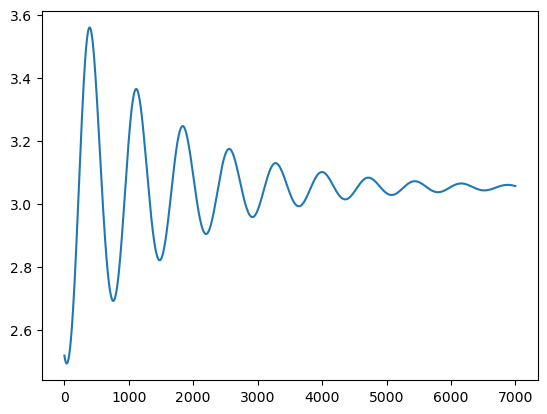

In [29]:
signal = results_1D[1,5,3000:,5,0,3].reshape(num_tsteps-3000)
plt.plot(signal.flatten())

#### Kymograph plots of Hes and Delta

C:\Users\kbmcd\AppData\Local\Temp\ipykernel_9608\3157078175.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3), constrained_layout=True)


Error in callback <function _draw_all_if_interactive at 0x00000217D31F9E10> (for post_execute):


KeyboardInterrupt: 

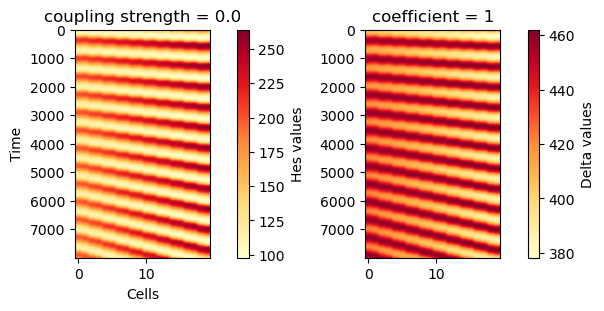

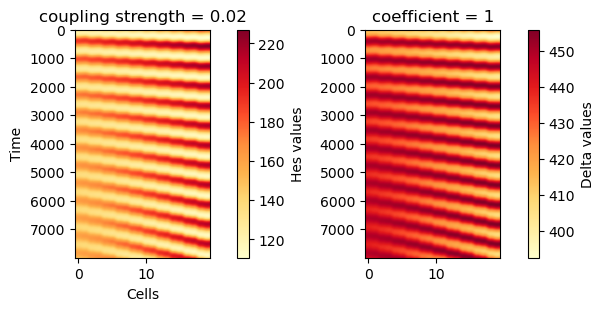

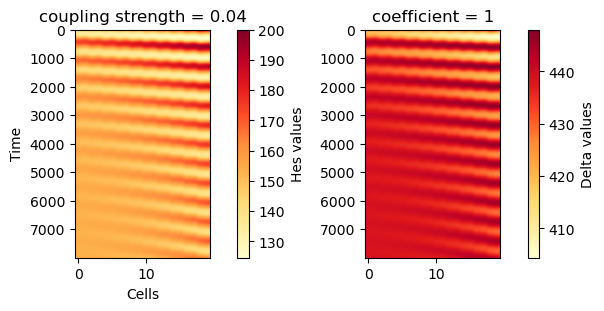

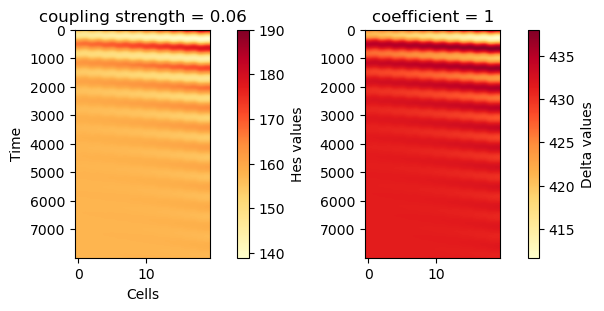

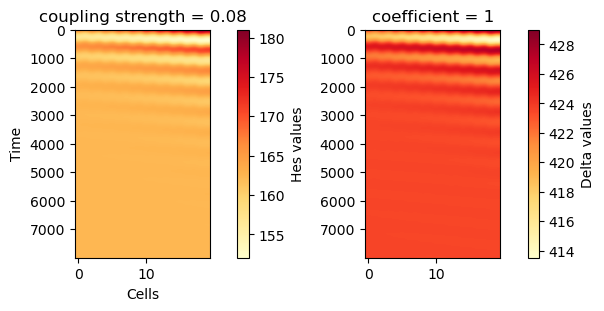

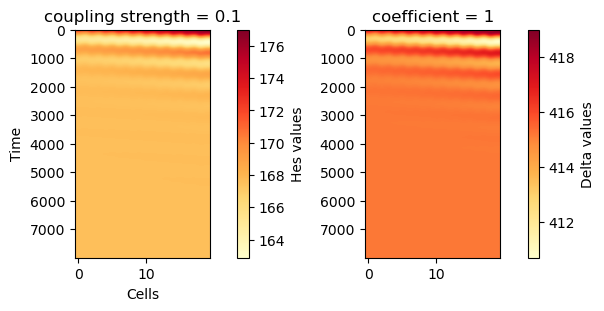

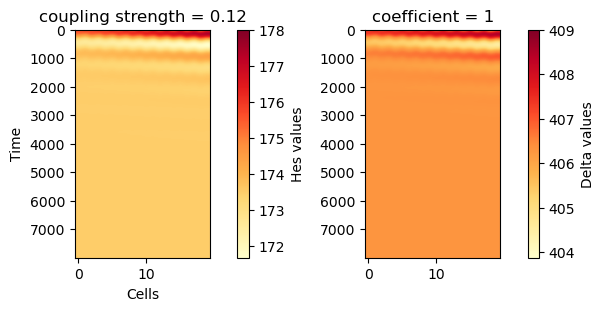

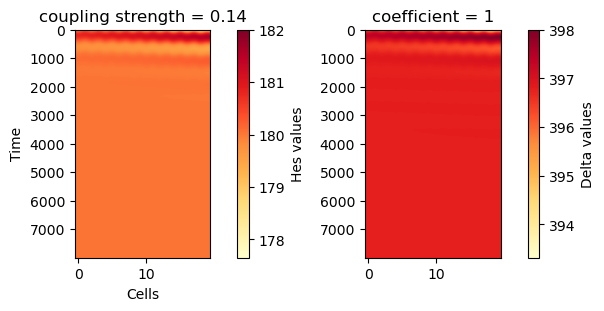

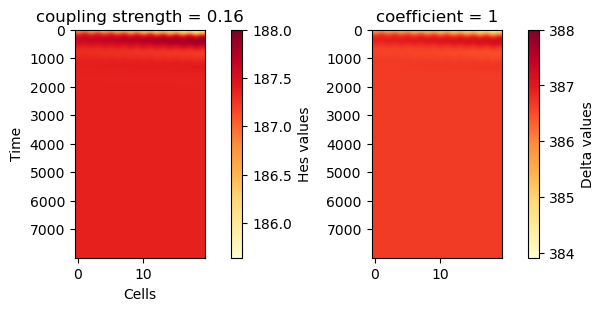

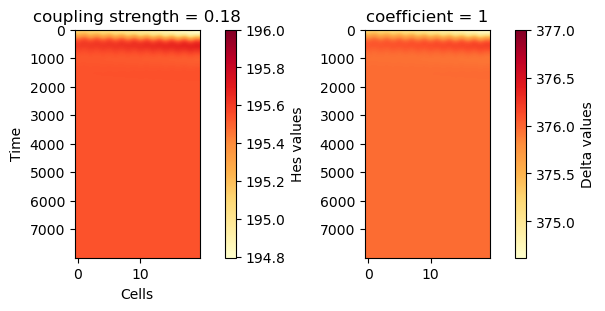

In [ ]:
# Set up the figure and two axes for vertically stacked images
for i in range(len(coeff_1D)):
    for j in range(len(coupling_strengths_1D)):

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3), constrained_layout=True)
        h_flat = results_1D[i,j,2000:,:,0,0].reshape(num_tsteps-2000, lattice.P)
        d_flat = results_1D[i,j,2000:,:,0,2].reshape(num_tsteps-2000, lattice.P)

        # Plot the first image
        im1 = ax1.imshow(h_flat, aspect = 'auto',  cmap='YlOrRd', vmin = np.min(h_flat), vmax = np.ceil(np.max(h_flat)))
        ax1.set_ylabel('Time')
        ax1.set_xlabel('Cells')
        ax1.set_title('coupling strength = ' + str(coupling_strengths_1D[j]))

        # Add colorbar for the first image
        cbar1 = fig.colorbar(im1, ax=ax1, orientation='vertical', fraction=0.1, pad=0.2)
        cbar1.set_label('Hes values')

        # Plot the second image
        im2 = ax2.imshow(d_flat, aspect = 'auto',  cmap='YlOrRd', vmin = np.min(d_flat), vmax = np.ceil(np.max(d_flat)))
        ax2.set_title('coefficient = ' + str(coeff_1D[i]))

        # Add colorbar for the second image
        cbar2 = fig.colorbar(im2, ax=ax2, orientation='vertical', fraction=0.1, pad=0.2)
        cbar2.set_label('Delta values')

        #fig.savefig('1D_h_d_coeff_' + str(coeff_1D[i]) + '_coup_' + str(coupling_strengths_1D[j]) + '.png', dpi=300, bbox_inches='tight')

### Fix constant part of signal

In [14]:
time_analysis = int(2000)
time_amplitude = int(3*num_tsteps/4)

### Calculate decay ratios for the results

In [15]:
decay_ratios = np.zeros([len(coeff_1D), len(coupling_strengths_1D), lattice.P])

for i in range(len(coeff_1D)):
    for j in range(len(coupling_strengths_1D)):
        for k in range(lattice.P):
            signal = results_1D[i,j,time_analysis:,k,0,0].reshape(num_tsteps-time_analysis)
            signal = signal - np.mean(signal)
            signal = signal.flatten()  # remove DC component

            decay_ratios[i,j,k] = decay_ratio(signal, time_frame = 600)
    

# take the mean over all cells in P direction
decay_ratio_means = np.mean(decay_ratios, axis = 2)


### Calculate periods for the results

In [16]:
# find periods for the 1D system, per cell 
periods_peaks = np.zeros([len(coeff_1D), len(coupling_strengths_1D), lattice.P])
# periods_fft = np.zeros([len(coeff_1D), len(coupling_strengths_1D), lattice.P])
# periods_autocorr = np.zeros([len(coeff_1D), len(coupling_strengths_1D), lattice.P])


for i in range(len(coeff_1D)):
    for j in range(len(coupling_strengths_1D)):
        for p in range(lattice.P):
            signal = results_1D[i,j,time_analysis:,p,0,0].flatten()
            
            # find the period of the oscillation for each cell
            periods_peaks[i,j,p]= estimate_period_from_peaks(signal, time = np.arange(int(num_tsteps - time_analysis))*dt)[0]
            #periods_fft[i,j,p] = estimate_period_fft(signal, time = np.arange(int(num_tsteps - time_analysis))*dt)[0]
            #periods_autocorr[i,j,p] = estimate_period_autocorr(signal, time = np.arange(int(num_tsteps - time_analysis))*dt, height=None)[0]
            # amplitudes[i,j,p] = estimate_amplitude_from_peaks(signal, height=amplitude_threshold)[0]
            #amplitudes[i,j,p] = estimate_amplitude_from_peaks(signal)[0]

# calculate the average period of the signal over all cells
period_peaks_avg = np.mean(periods_peaks, axis = 2)

### Calculate amplitude for the last peaks of signal

In [17]:
amplitudes = np.zeros([len(coeff_1D), len(coupling_strengths_1D), lattice.P])

for i in range(len(coeff_1D)):
    for j in range(len(coupling_strengths_1D)):
        for k in range(lattice.P):
            signal = results_1D[i,j,time_amplitude:,k,0,0].flatten()

            amplitudes[i,j,k] = estimate_amplitude_from_peaks(signal)[0]

amplitudes_mean = np.mean(amplitudes, axis =2)

### Calculate the phase gradient of the system 

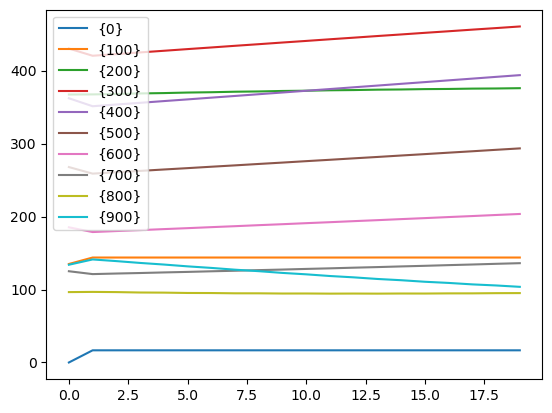

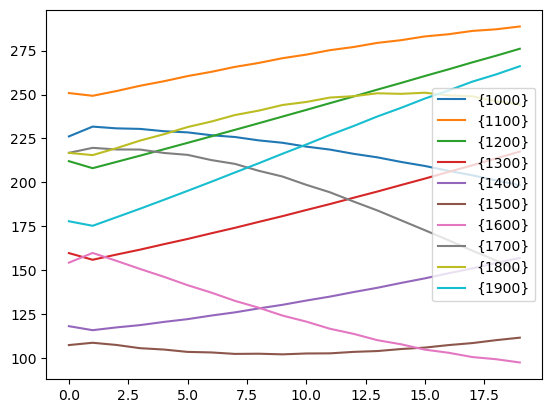

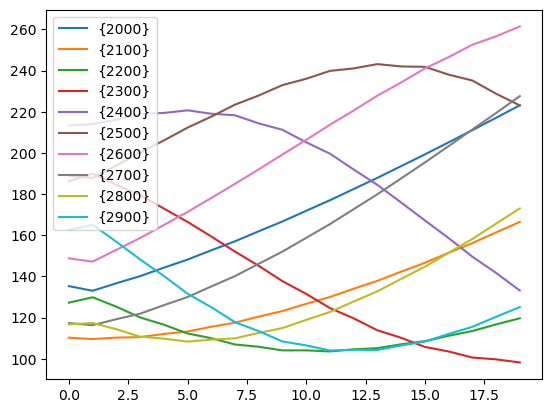

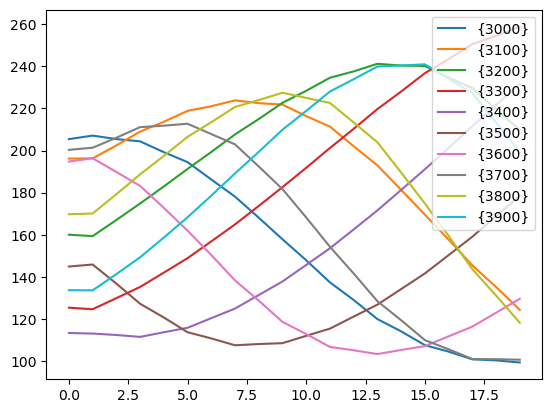

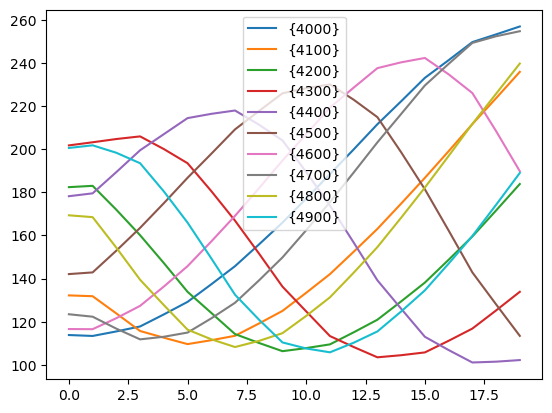

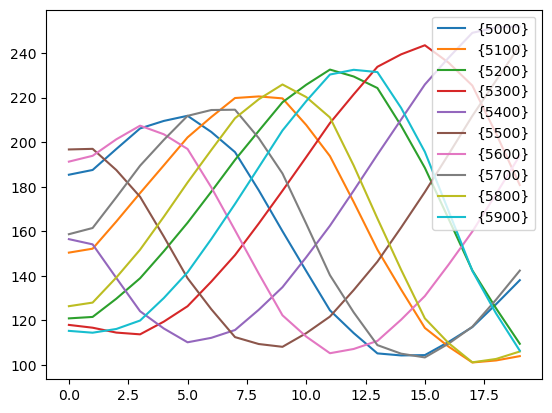

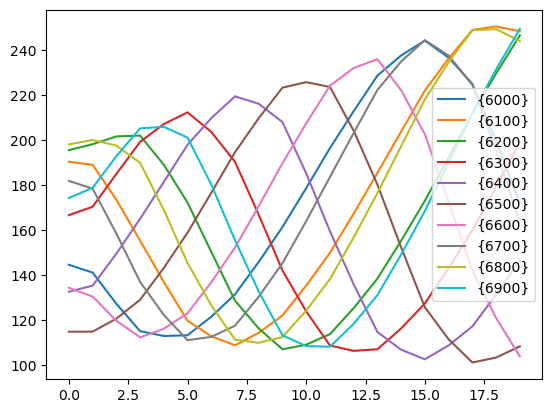

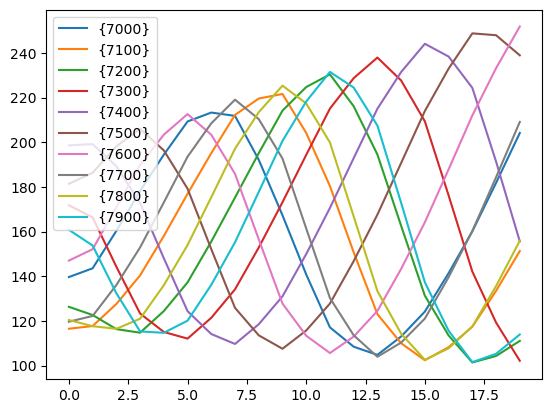

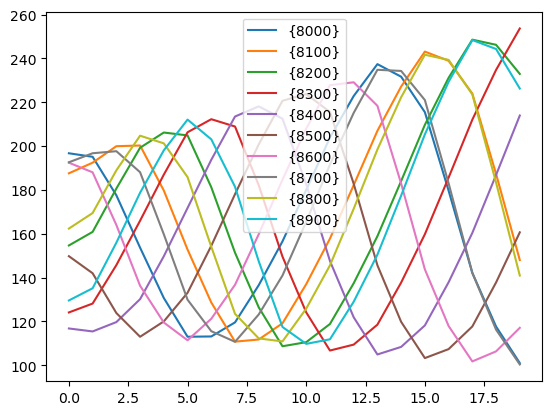

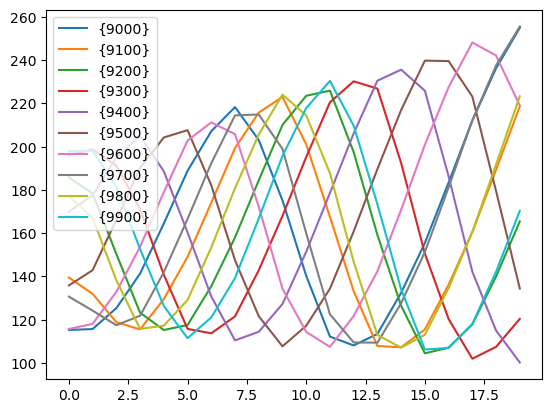

In [59]:
from scipy.ndimage import uniform_filter1d

spatial_signal = results_1D[0,0,:,:,0,0]
spatial_signal_smooth = np.zeros((num_tsteps, lattice.P))
y_fit = np.zeros((num_tsteps, lattice.P))

for i in range(num_tsteps):
    spatial_signal_smooth[i,:] = uniform_filter1d(spatial_signal[i,:], size=2, mode='reflect')

for z in range(10):
    plt.figure()
    for t in range(10):
        #plt.plot(spatial_signal[t*100+z*1000,:], label = {t*100+z*1000})
        plt.plot(spatial_signal_smooth[t*100+z*1000,:], label = {t*100+z*1000})
        
    plt.legend()

Total phase shift: -4.43 rad
Approximate number of cycles: -0.71


<Figure size 640x480 with 0 Axes>

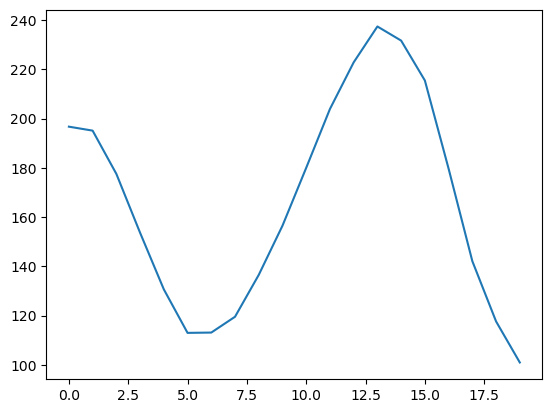

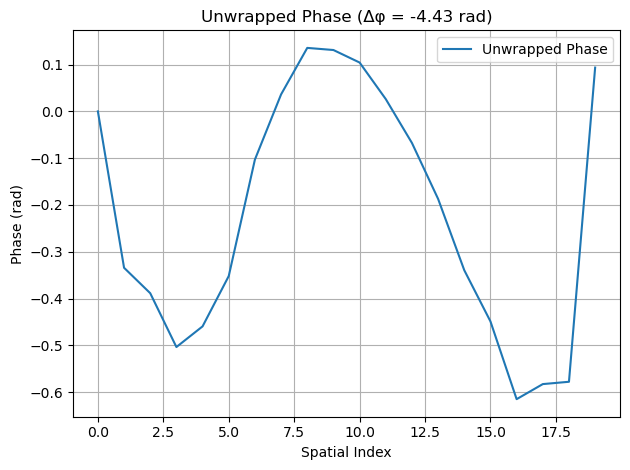

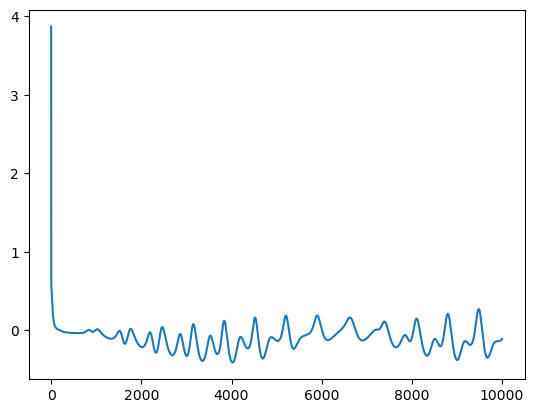

In [66]:
from scipy.signal import hilbert
# Pick your time index
idx = 8000
signal = spatial_signal_smooth[idx, :]

# Compute analytic signal and phase
analytic_signal = hilbert(signal)
phase = np.unwrap(np.angle(analytic_signal))  # unwrap avoids jumps across -pi/pi
#phase = np.angle(analytic_signal)

# Shift phase so it starts at zero
if phase[-1] < phase[0]:
    phase *= -1  # flip phase direction if decreasing

phase -= phase[0]  # make it start at 0

# Total phase shift
total_phase_shift = phase[-1]
n_cycles = total_phase_shift / (2 * np.pi)
# Total phase shift = phase(end) - phase(start)
total_phase_shift = phase[-1] - phase[0]
total_phase_shift = np.sum(phase)
# Also compute number of full cycles:
n_cycles = total_phase_shift / (2 * np.pi)

# Print results
print(f"Total phase shift: {total_phase_shift:.2f} rad")
print(f"Approximate number of cycles: {n_cycles:.2f}")

# Optional: plot
plt.figure()

plt.figure()
plt.plot(signal)

plt.figure()
plt.plot(phase, label="Unwrapped Phase")
plt.title(f"Unwrapped Phase (Δφ = {total_phase_shift:.2f} rad)")
plt.xlabel("Spatial Index")
plt.ylabel("Phase (rad)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

total_phase_shift = np.zeros(num_tsteps)
for i in range(num_tsteps):
    signal = spatial_signal_smooth[i, :]

    # Compute analytic signal and phase
    analytic_signal = hilbert(signal)
    phase = np.unwrap(np.angle(analytic_signal))  # unwrap avoids jumps across -pi/pi

    # Total phase shift = phase(end) - phase(start)
    total_phase_shift[i] = phase[-1] - phase[0]

plt.plot(total_phase_shift)


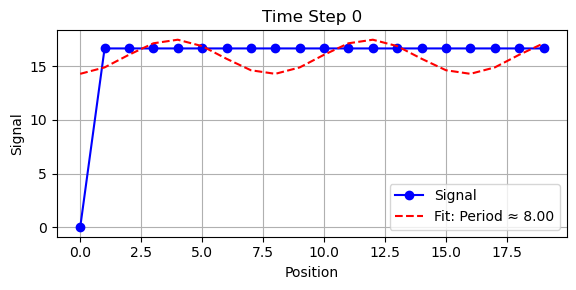

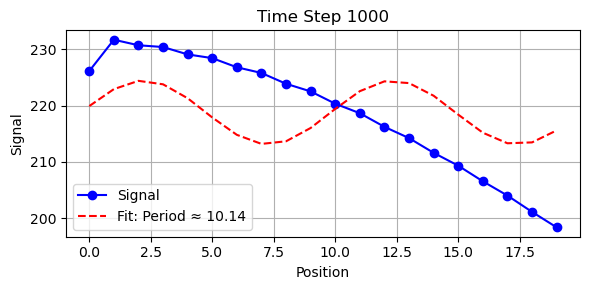

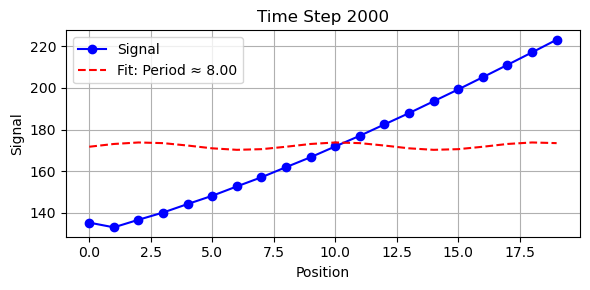

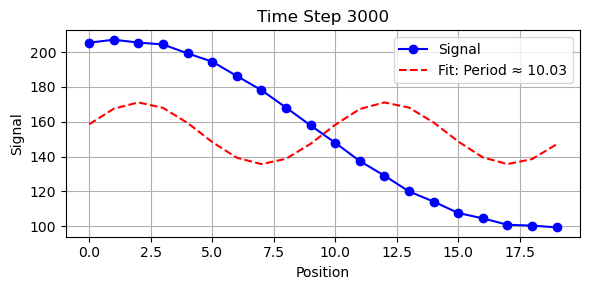

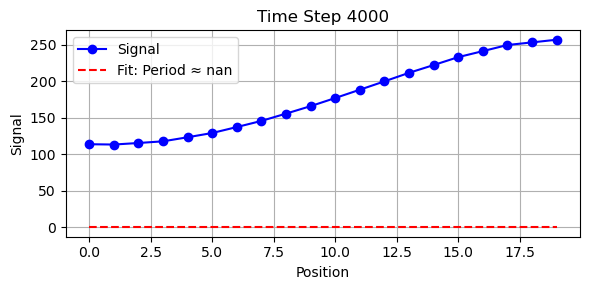

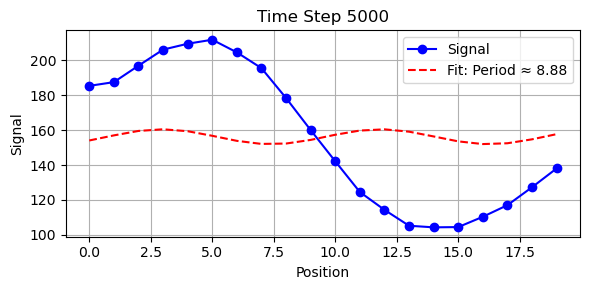

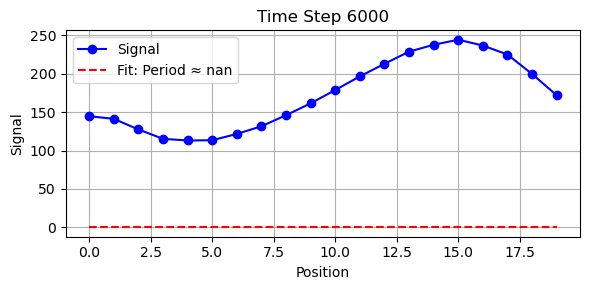

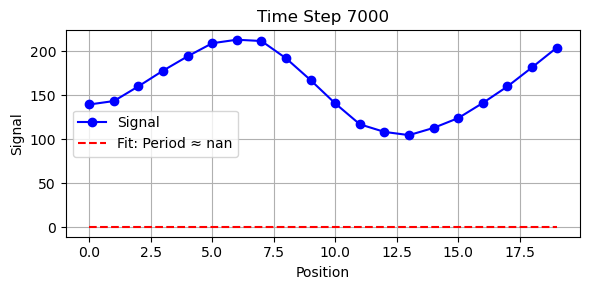

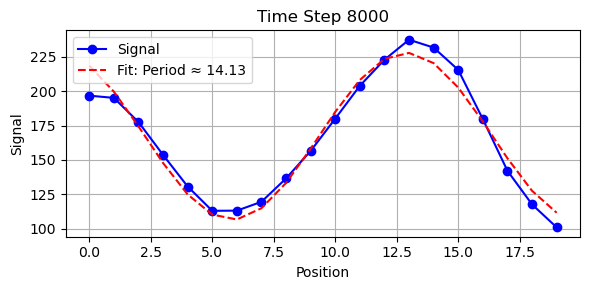

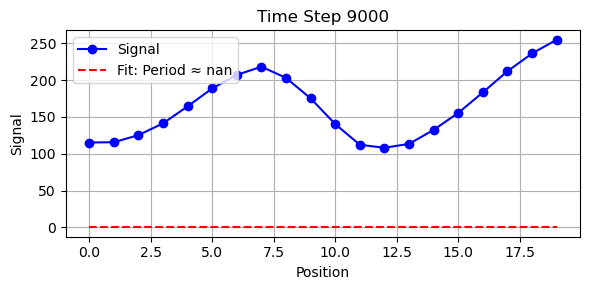

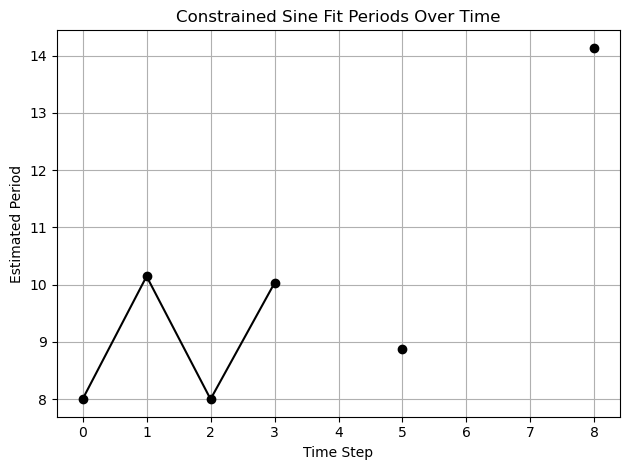

In [70]:

from scipy.optimize import curve_fit

# Define sine function
def sine_model(x, A, k, phi, offset):
    return A * np.sin(k * x + phi) + offset

# Set your minimum allowed spatial period
min_period = 8  # in spatial units (e.g., index positions)
max_k = 2 * np.pi / min_period  # maximum allowed k for the fit

# Data setup
x_data = np.arange(20)
estimated_periods = []

for i in range(10):
    t = 1000*i
    y_data = spatial_signal_smooth[t, :]

    guess = [np.ptp(y_data)/2, 2*np.pi/10, 0, np.mean(y_data)]

    # Set bounds for parameters: (A, k, phi, offset)
    # Amplitude > 0, 0 < k <= max_k, unrestricted phase/offset
    lower_bounds = [0, 0, -np.inf, -np.inf]
    upper_bounds = [np.inf, max_k, np.inf, np.inf]

    try:
        params, _ = curve_fit(sine_model, x_data, y_data, p0=guess,
                              bounds=(lower_bounds, upper_bounds))
        A, k, phi, offset = params
        period = 2 * np.pi / abs(k)
    except RuntimeError:
        period = np.nan
        params = [0, 0, 0, 0]

    estimated_periods.append(period)
    y_fit = sine_model(x_data, *params)

    # Plot each fit
    plt.figure(figsize=(6, 3))
    plt.plot(x_data, y_data, 'bo-', label='Signal')
    plt.plot(x_data, y_fit, 'r--', label=f'Fit: Period ≈ {period:.2f}')
    plt.title(f'Time Step {t}')
    plt.xlabel("Position")
    plt.ylabel("Signal")
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()

# Plot estimated periods over time
estimated_periods = np.array(estimated_periods)
plt.figure()
plt.plot(estimated_periods, 'k-o')
plt.title("Constrained Sine Fit Periods Over Time")
plt.xlabel("Time Step")
plt.ylabel("Estimated Period")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
signal_matrix = results_1D[4,3,3000:,:,0,0]
# Your signal: shape (n_timepoints, n_cells)
# Step 1: Apply Hilbert transform along time (axis=0)
analytic_signal = hilbert(signal_matrix, axis=0)

# Step 2: Get instantaneous phase (still shape: n_timepoints × n_cells)
instantaneous_phase = np.angle(analytic_signal)

# Step 3: (Optional) Average over a time window
# Example: average from time index 1000 to 2000
mean_phase = np.mean(instantaneous_phase[1000:2000, :], axis=0)  # axis=0 → averaging over time

# Step 4: Compute spatial phase gradient (along cells)
# dx = spacing between cells (in spatial units; use 1 if uniform and unknown)
dx = 1
phase_gradient = np.gradient(mean_phase, dx)

unwrapped_phase = np.unwrap(instantaneous_phase, axis=0)
phase_gradient_time_resolved = np.gradient(unwrapped_phase, axis=1) / dx

total_phase_shift = np.sum(np.gradient(mean_phase_unwrapped, dx))

[ 0.00266313  0.0014172   0.00202973 ... -0.00148674 -0.00089648
  0.00170965]


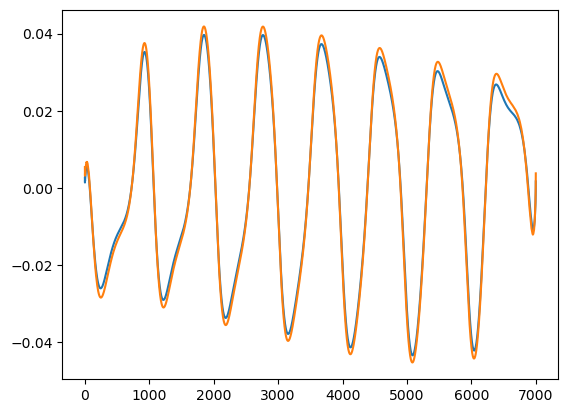

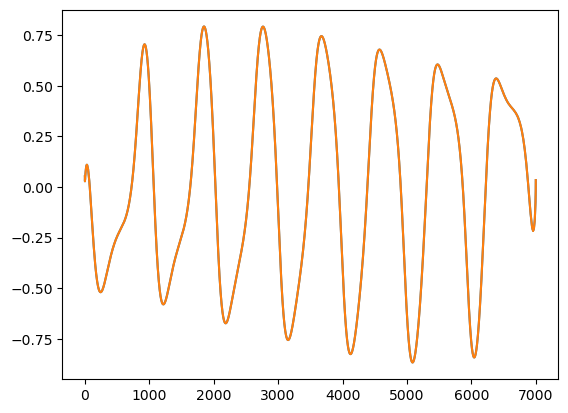

In [103]:
total_phase_gradient_2 = np.mean(phase_gradient_time_resolved, axis=1)
print(total_phase_gradient_2)
plt.plot(total_phase_gradient_2)

total_phase_gradient = (unwrapped_phase[:,-1] - unwrapped_phase[:,0]) / (lattice.P - 1)
plt.plot(total_phase_gradient)

total_phase_gradient_3 = np.sum(phase_gradient_time_resolved, axis = 1)
plt.figure()
plt.plot(total_phase_gradient_3)

total_phase_gradient_4 = np.sum(phase_gradient_time_resolved[:,5:-5], axis = 1)
plt.plot(total_phase_gradient_3)

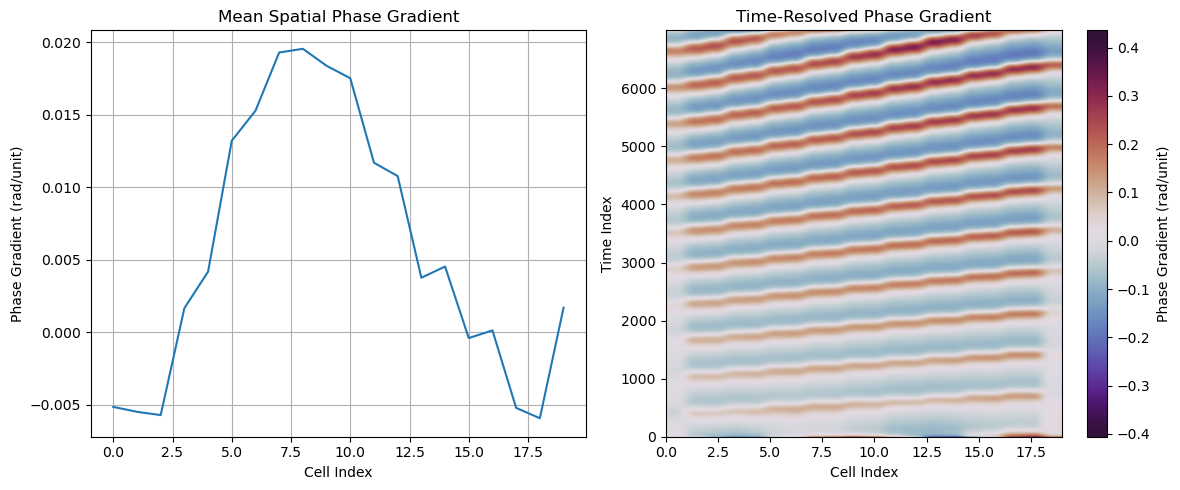

In [81]:
# Plot mean phase gradient
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(phase_gradient)
plt.title("Mean Spatial Phase Gradient")
plt.xlabel("Cell Index")
plt.ylabel("Phase Gradient (rad/unit)")
plt.grid(True)

# Plot time-resolved phase gradient
plt.subplot(1, 2, 2)
im = plt.imshow(phase_gradient_time_resolved, 
                aspect='auto', 
                origin='lower', 
                cmap='twilight_shifted',
                extent=[0, signal_matrix.shape[1]-1, 0, signal_matrix.shape[0]-1])
plt.colorbar(im, label='Phase Gradient (rad/unit)')
plt.title("Time-Resolved Phase Gradient")
plt.xlabel("Cell Index")
plt.ylabel("Time Index")

plt.tight_layout()
plt.show()

In [91]:
total_phase_gradient = (unwrapped_phase[:,-1] - unwrapped_phase[:,0]) / (lattice.P - 1)

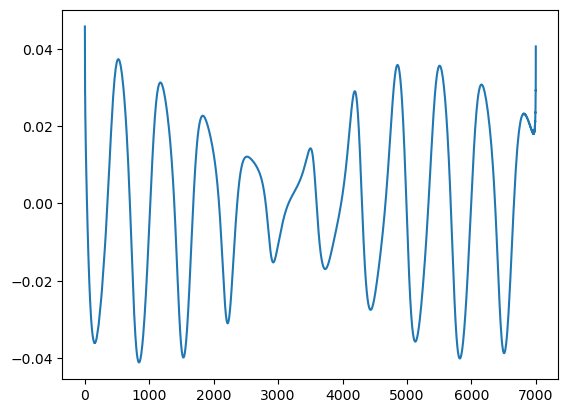

In [92]:
plt.plot(total_phase_gradient)

(20,)
[-0.46251851 -0.12452407 -0.14202718  0.02380759  0.01614219  0.12889138
  0.14178715  0.20200005  0.23952683  0.23852148  0.29406933  0.22646003
  0.28425278  0.14733868  0.18856255 -0.01933975 -0.00511933 -0.29110661
 -0.29462867 -0.78205302]
phase gradient is [ 0.33799444  0.16024566  0.07416583  0.07908469  0.0525419   0.06282248
  0.03655434  0.04886984  0.01826072  0.02727125 -0.00603073 -0.00490827
 -0.03956068 -0.04784512 -0.08333921 -0.09684094 -0.13588343 -0.14475467
 -0.2454732  -0.48742435]
(20,)
[-0.06138987 -0.00942108 -0.01180072  0.00582346  0.00540208  0.01405956
  0.01496872  0.01808963  0.01997243  0.01860968  0.02111728  0.01578023
  0.01850203  0.00954093  0.01196819 -0.00052422  0.00092891 -0.01647986
 -0.01715513 -0.05801682]
phase gradient is [ 0.05196879  0.02479458  0.00762227  0.0086014   0.00411805  0.00478332
  0.00201504  0.00250186  0.00026003  0.00057242 -0.00141473 -0.00130763
 -0.00311965 -0.00326692 -0.00503258 -0.00551964 -0.00797782 -0.0090420

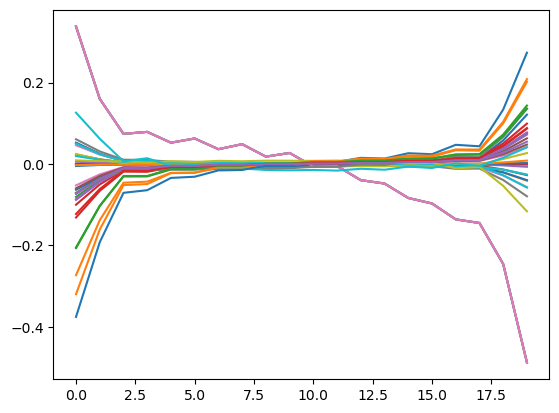

In [69]:
from scipy.signal import hilbert

for i in range(len(coeff_1D)):
    for j in range(len(coupling_strengths_1D)):
            signal_matrix = results_1D[i,j,3000,:,0,0]
            print(signal_matrix.shape)
            # signal_matrix: shape (n_cells, n_timepoints)
            analytic_signal = hilbert(signal_matrix, axis=0)
            instantaneous_phase = np.angle(analytic_signal)  # phase at each time
            print(instantaneous_phase)
            
            # # Optionally average over a time window
            # mean_phase = np.mean(instantaneous_phase[:, start:end], axis=1)

            # # Compute gradient
            # phase_gradient = np.gradient(mean_phase, dx)
            phase_gradient = np.gradient(instantaneous_phase)
            print('phase gradient is', phase_gradient)

            plt.plot(phase_gradient)

### Plot the mean decay rate, period and final amplitude

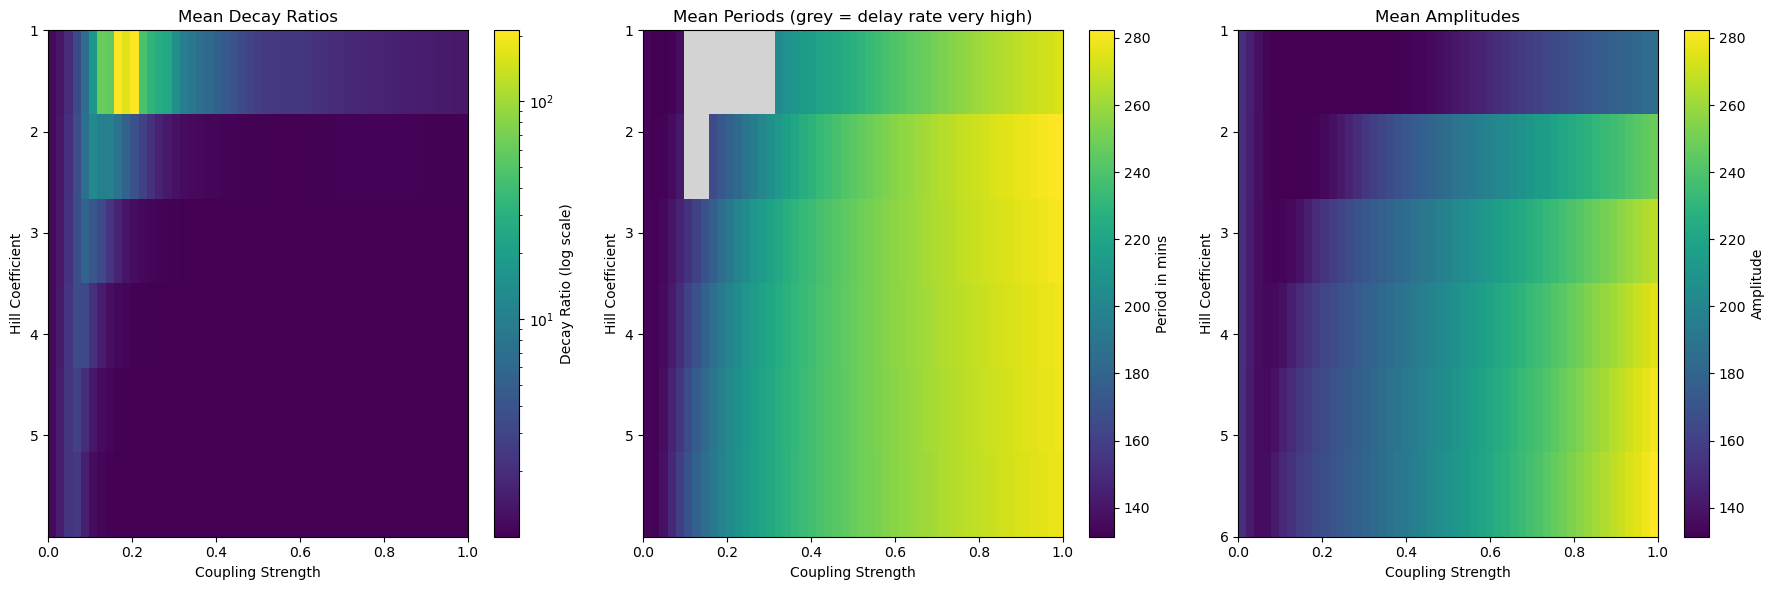

In [18]:
# Set up the figure with two subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# ======== Plot 1: Decay Ratios (log scale) ========
im1 = axes[0].imshow(decay_ratio_means, 
                     aspect='auto', 
                     interpolation='none', 
                     norm=LogNorm(vmin=np.min(decay_ratio_means[decay_ratio_means > 0]), 
                                  vmax=np.max(decay_ratio_means)),
                     extent=[coupling_strengths_1D[0], coupling_strengths_1D[-1], 
                             coeff_1D[-1], coeff_1D[0]])
axes[0].set_title('Mean Decay Ratios')
axes[0].set_xlabel('Coupling Strength')
axes[0].set_ylabel('Hill Coefficient')
axes[0].set_yticks([1, 2, 3, 4, 5])
fig.colorbar(im1, ax=axes[0], label='Decay Ratio (log scale)')

# ======== Plot 2: Periods (masked by decay) ========
masked_periods = np.ma.masked_where(decay_ratio_means > 10, period_peaks_avg)
cmap = cm.viridis.copy()
cmap.set_bad(color='lightgrey')

im2 = axes[1].imshow(masked_periods, 
                     aspect='auto', 
                     interpolation='none', 
                     cmap=cmap,
                     extent=[coupling_strengths_1D[0], coupling_strengths_1D[-1], 
                             coeff_1D[-1], coeff_1D[0]])

axes[1].set_title('Mean Periods (grey = delay rate very high)')
axes[1].set_xlabel('Coupling Strength')
axes[1].set_ylabel('Hill Coefficient')
axes[1].set_yticks([1, 2, 3, 4, 5])
fig.colorbar(im2, ax=axes[1], label='Period in mins')

# ======== Plot 3: Amplitudes ========
im3 = axes[2].imshow(amplitudes_mean, 
                     aspect='auto', 
                     interpolation='none', 
                     cmap=cmap,
                     extent=[coupling_strengths_1D[0], coupling_strengths_1D[-1], 
                             coeff_1D[-1], coeff_1D[0]])

axes[2].set_title('Mean Amplitudes')
axes[2].set_xlabel('Coupling Strength')
axes[2].set_ylabel('Hill Coefficient')
axes[2].set_yticks([1, 2, 3, 4, 5,6])
fig.colorbar(im2, ax=axes[2], label='Amplitude')

plt.tight_layout()
plt.show()

### Relation between Coupling Strength and period

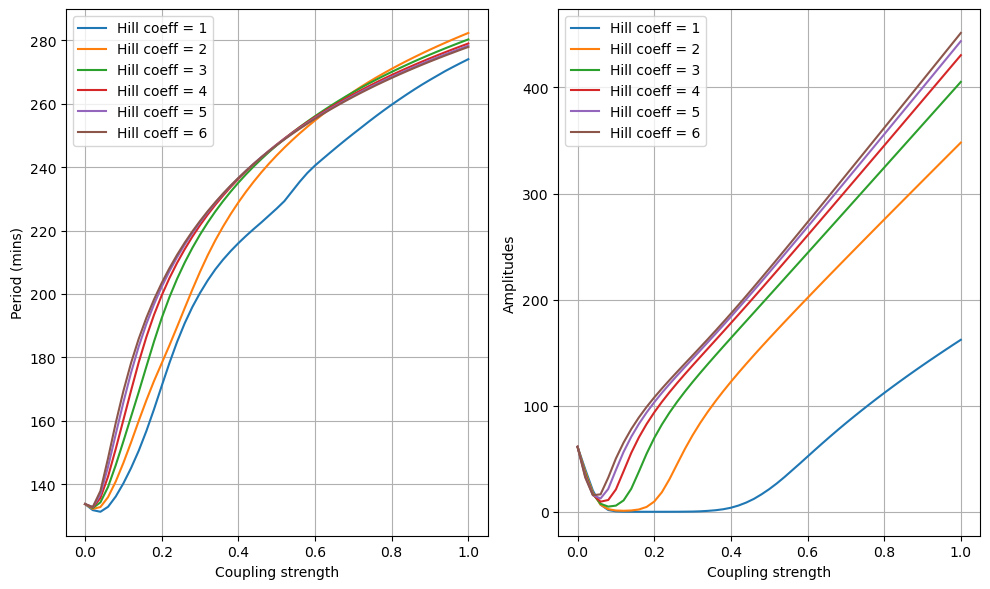

In [79]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
for n in range(len(coeff_1D)):
    plt.plot(coupling_strengths_1D, period_peaks_avg[n,:], label = f'Hill coeff = {n+1}')
plt.xlabel('Coupling strength')
plt.ylabel('Period (mins)')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
for n in range(len(coeff_1D)):
    plt.plot(coupling_strengths_1D, amplitudes_mean[n,:], label = f'Hill coeff = {n+1}')
plt.xlabel('Coupling strength')
plt.ylabel('Amplitudes')
plt.grid()
plt.legend()

plt.tight_layout()


#### All plots for decay ratio

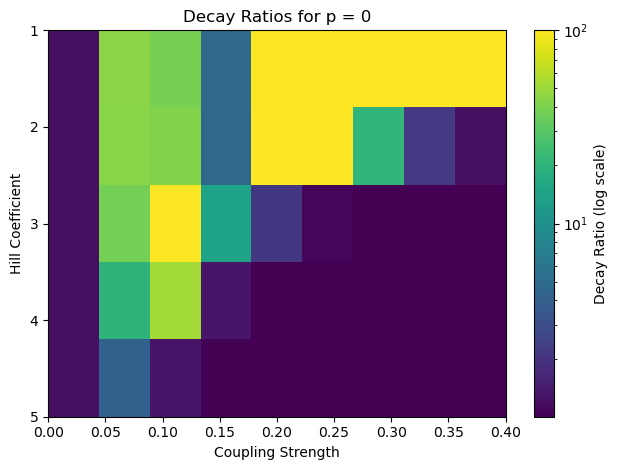

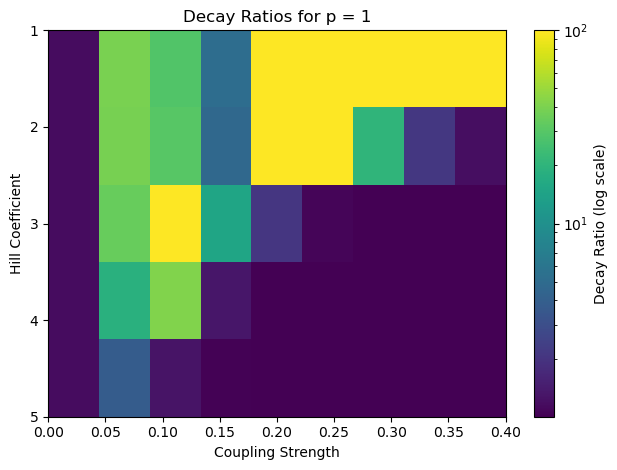

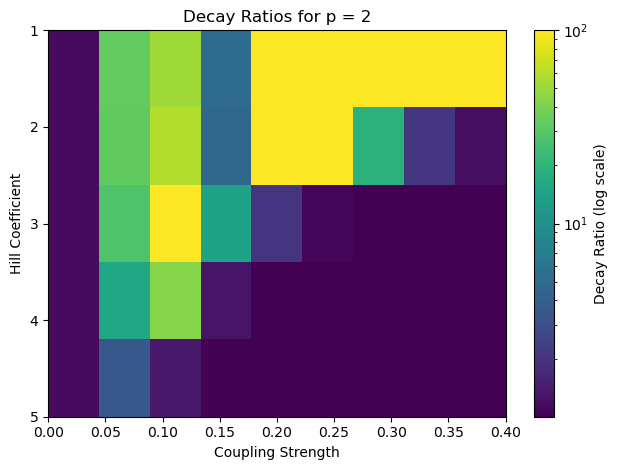

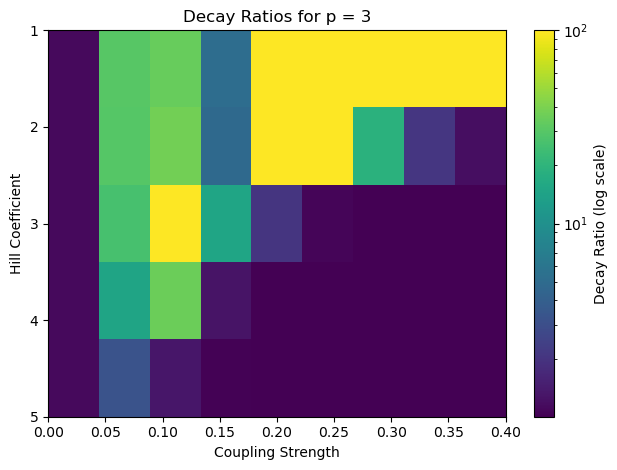

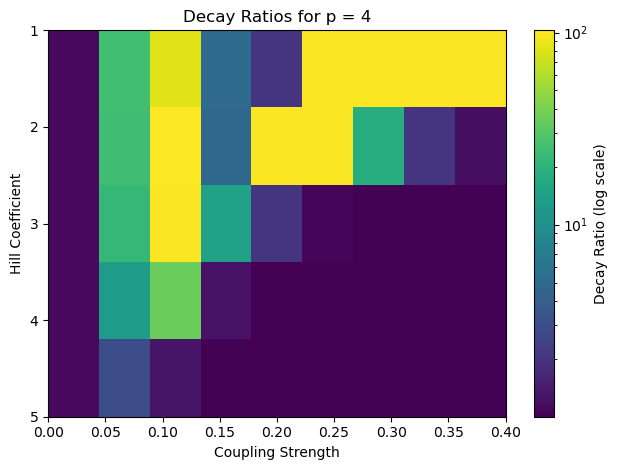

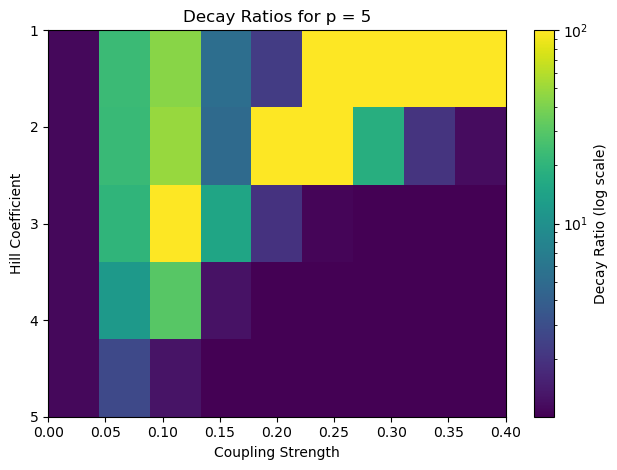

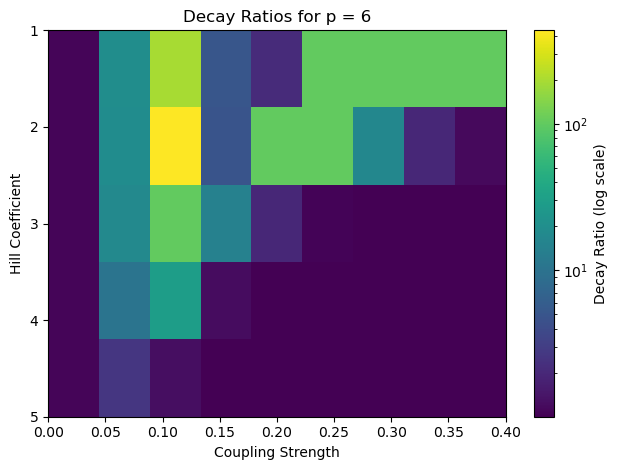

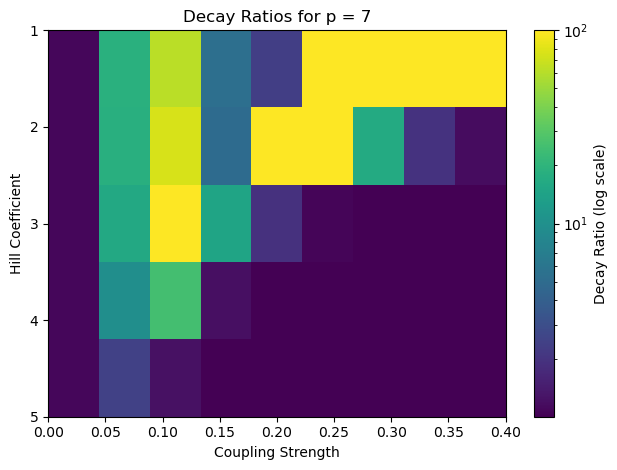

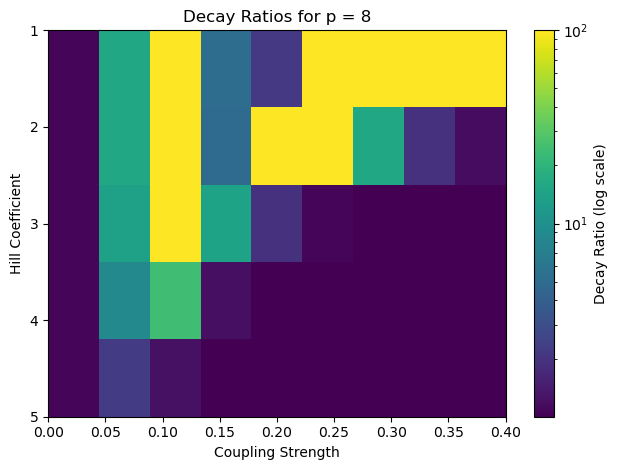

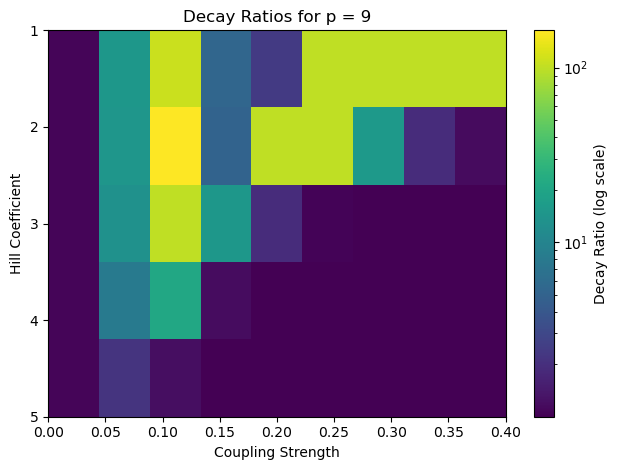

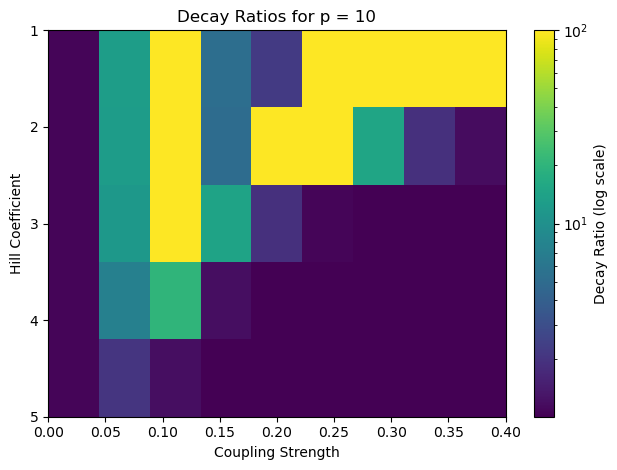

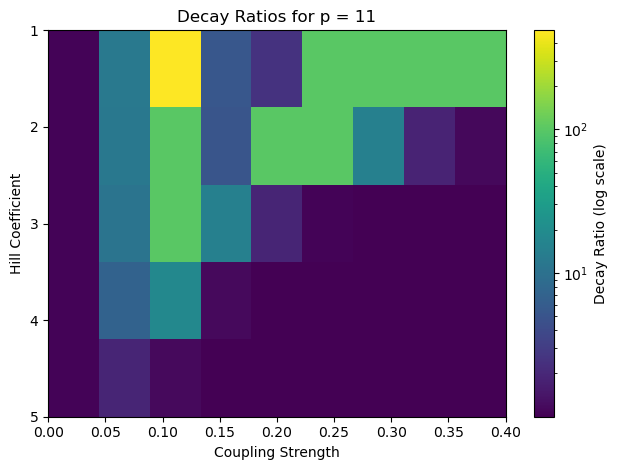

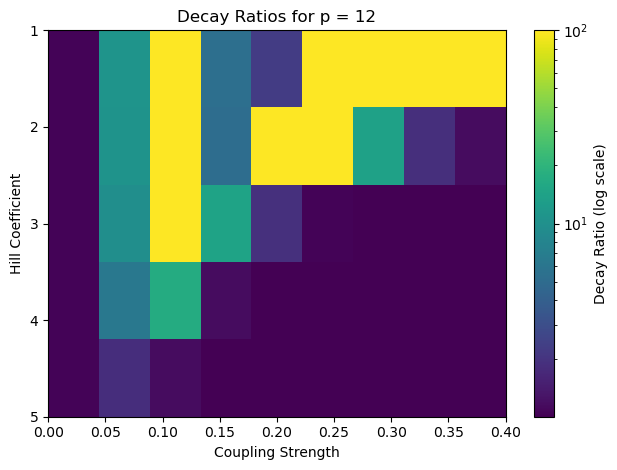

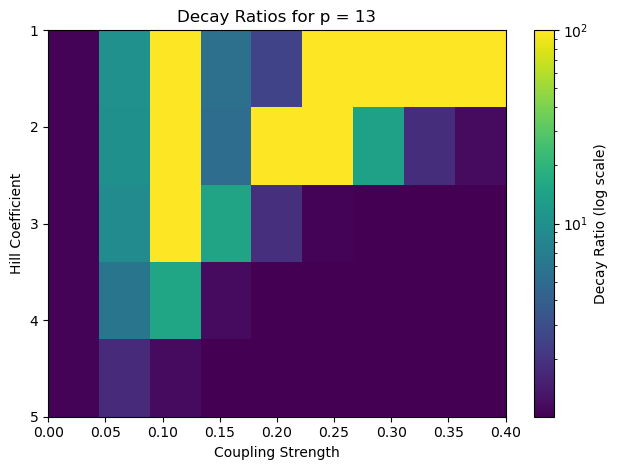

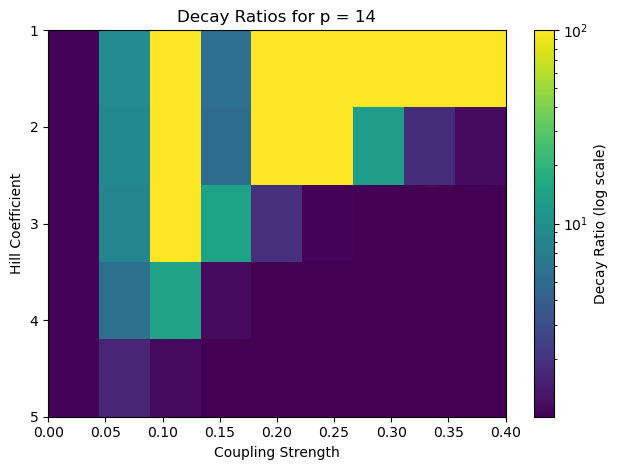

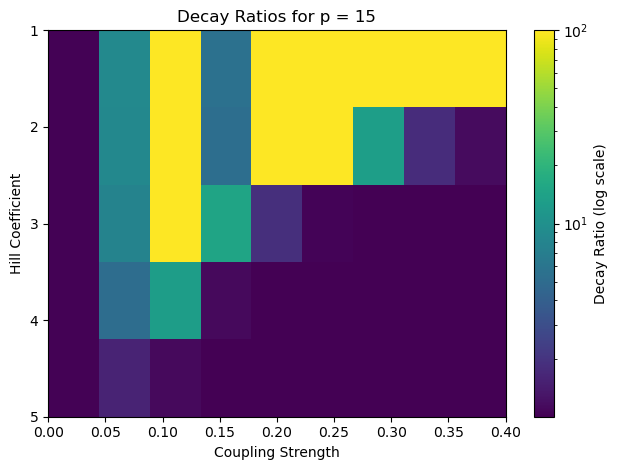

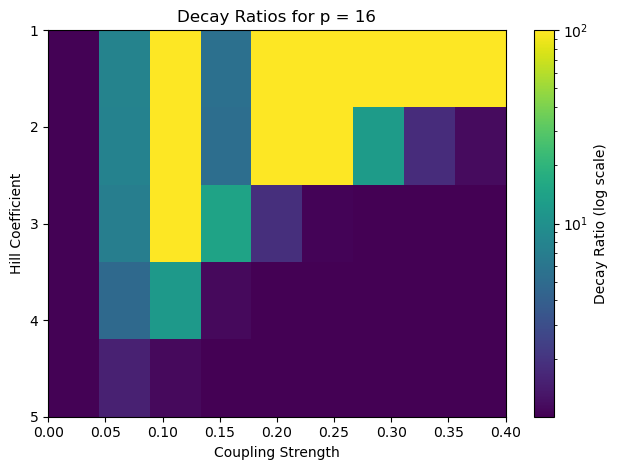

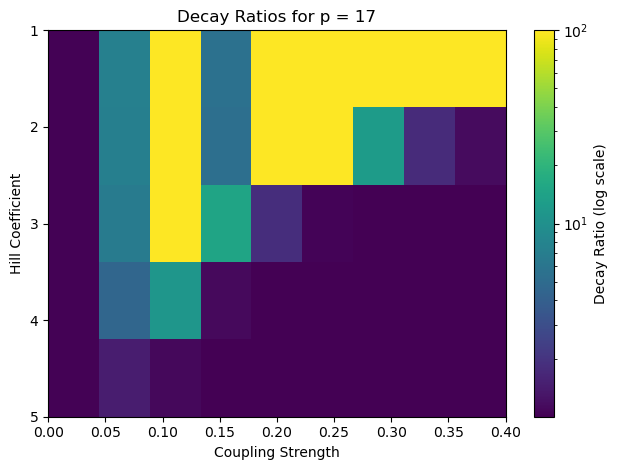

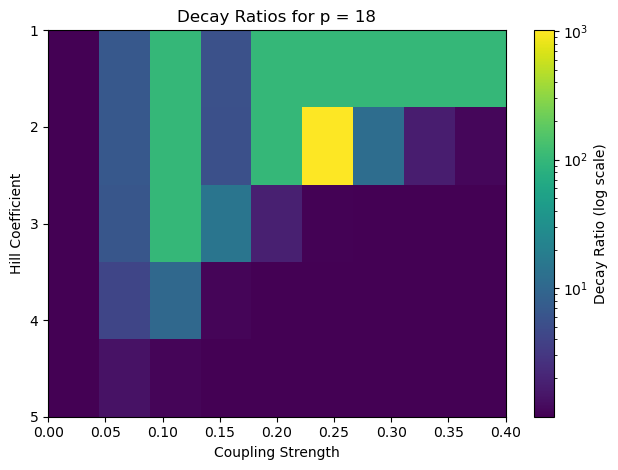

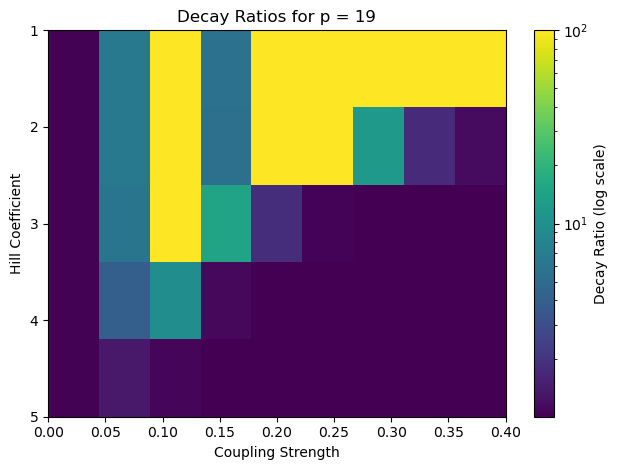

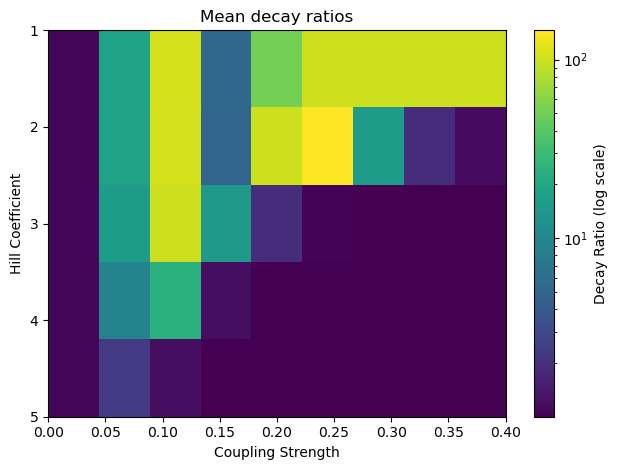

In [ ]:

for k in range(lattice.P): 
    decay_ratio_k = decay_ratios[:,:,k]

    plt.figure()

    # Apply logarithmic color scale
    plt.imshow(decay_ratio_k, 
            aspect='auto', 
            interpolation='none', 
            norm=LogNorm(vmin=np.min(decay_ratio_k[decay_ratio_k > 0]), vmax=np.max(decay_ratio_k)),
            extent=[coupling_strengths_1D[0], coupling_strengths_1D[-1], coeff_1D[-1], coeff_1D[0]])

    plt.colorbar(label='Decay Ratio (log scale)')
    plt.xlabel('Coupling Strength')
    plt.ylabel('Hill Coefficient')
    plt.title(f'Decay Ratios for p = {k}')

    # Set y-ticks explicitly
    plt.yticks([1, 2, 3, 4, 5])

    plt.tight_layout()
    plt.show()

plt.figure()


# Apply logarithmic color scale
plt.imshow(decay_ratio_means, 
        aspect='auto', 
        interpolation='none', 
        norm=LogNorm(vmin=np.min(decay_ratio_means[decay_ratio_means > 0]), vmax=np.max(decay_ratio_means)),
        extent=[coupling_strengths_1D[0], coupling_strengths_1D[-1], coeff_1D[-1], coeff_1D[0]])

plt.colorbar(label='Decay Ratio (log scale)')
plt.xlabel('Coupling Strength')
plt.ylabel('Hill Coefficient')
plt.title(f'Mean decay ratios')

# Set y-ticks explicitly
plt.yticks([1, 2, 3, 4, 5])

plt.tight_layout()
plt.show()

#### All plots for peak period

In [ ]:
for k in range(lattice.P): 
    periods_k = periods_peaks[:,:,k]
    
    plt.figure()

    # Apply logarithmic color scale
    plt.imshow(periods_k, 
            aspect='auto', 
            interpolation='none')

    plt.colorbar(label='Period in mins')
    plt.xlabel('Coupling Strength')
    plt.ylabel('Hill Coefficient')
    plt.title(f'Periods p = {k}')

    # Set y-ticks explicitly
    plt.yticks([1, 2, 3, 4, 5])

    plt.tight_layout()
    plt.show()

plt.figure()

# take the mean over all cells in P direction

# Apply logarithmic color scale
plt.imshow(period_peaks_avg, 
        aspect='auto', 
        interpolation='none')

plt.colorbar(label='Period in mins')
plt.xlabel('Coupling Strength')
plt.ylabel('Hill Coefficient')
plt.title(f'Mean periods')

# Set y-ticks explicitly
plt.yticks([1, 2, 3, 4, 5])

plt.tight_layout()
plt.show()

### Different types of period calculation

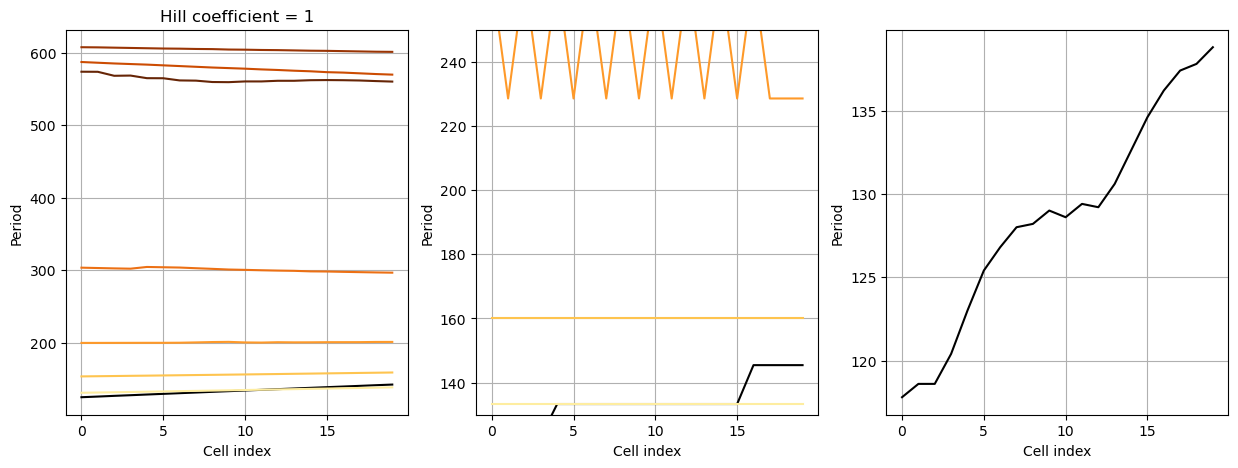

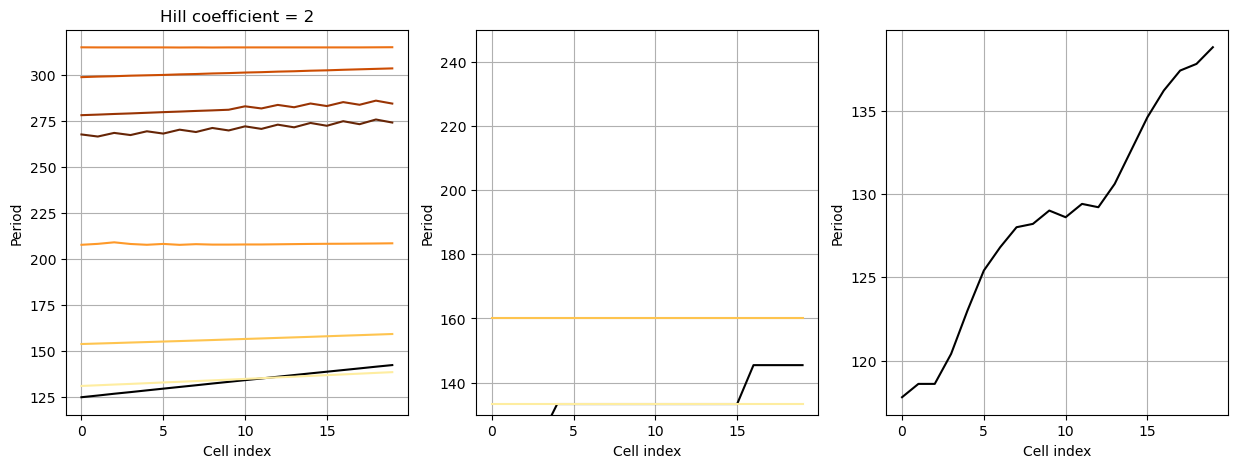

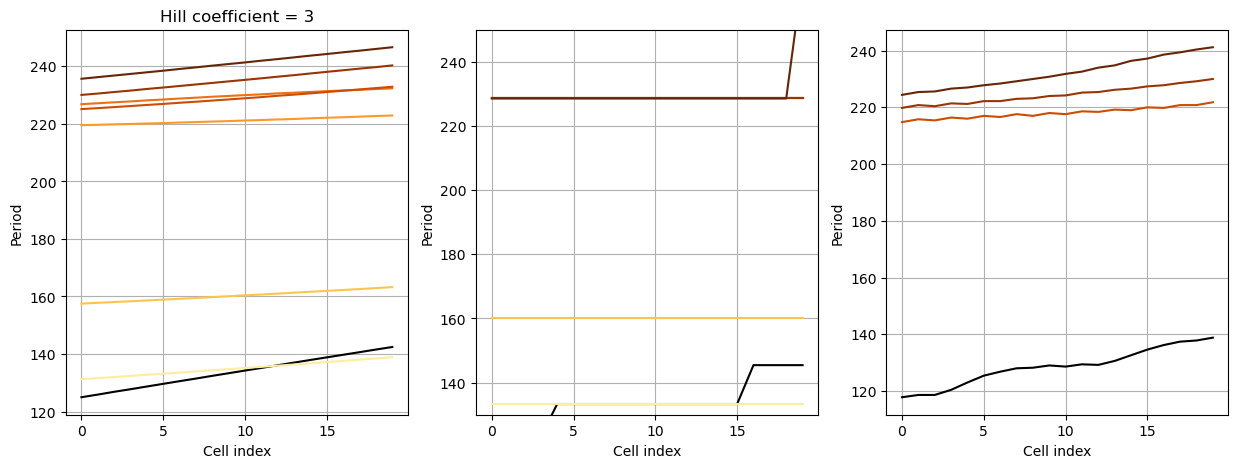

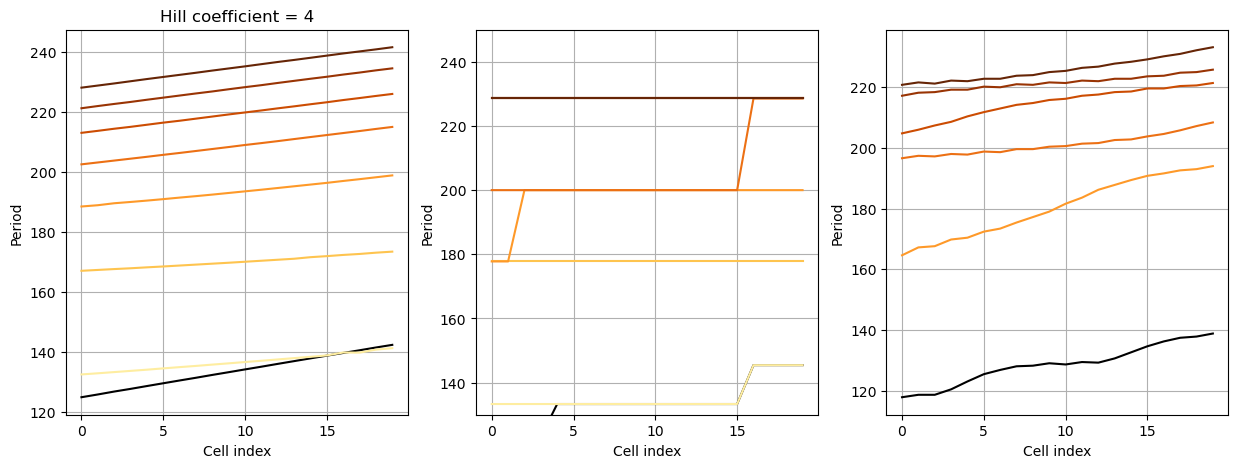

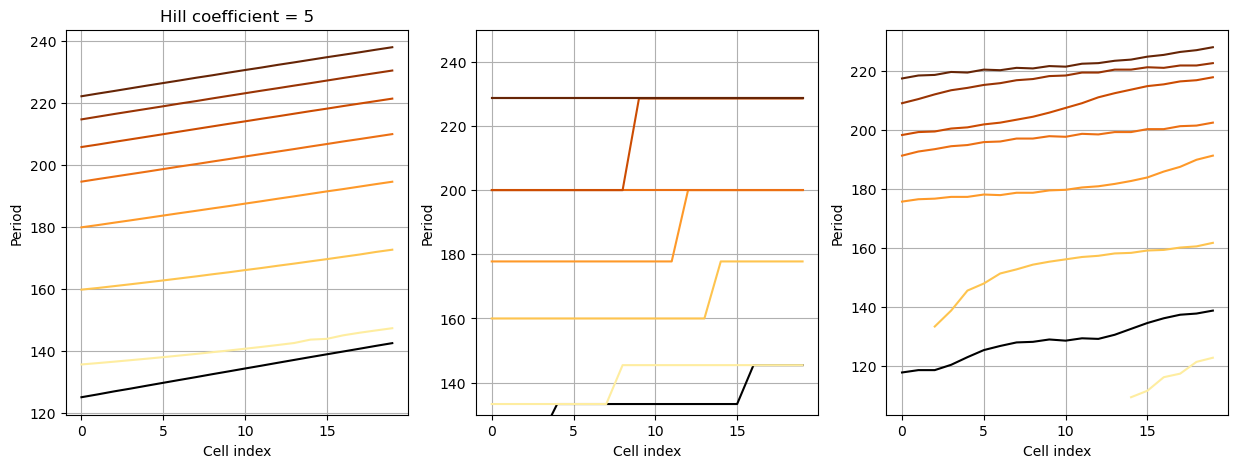

In [7]:
colors_coeffs = ['#ffffb2', '#fecc5c', '#fd8d3c', '#f03b20', '#bd0026']
colors_strengths = ['#feeda0', '#fec44f', '#fe9929', '#ec7014', '#cc4c02', '#993404', '#662506']


for i in range(len(coeff_1D)):
    plt.figure(figsize=(15,5))
    plt.subplot(1, 3, 1)
    plt.plot(np.arange(lattice.P), periods_peaks[0,0,:], label = 'no coupling periods', color = 'black')
    plt.xlabel('Cell index')
    plt.ylabel('Period')
    plt.grid()
    
    for j in range(1, len(coupling_strengths_1D)-1):
        plt.plot(np.arange(lattice.P), periods_peaks[i,j,:], color = colors_strengths[j-1], label = f'coeff = {coeff_1D[i]}, coup_strength = {coupling_strengths_1D[j]}')
    plt.title(f'Hill coefficient = {coeff_1D[i]}')


    plt.subplot(1,3,2)
    plt.plot(np.arange(lattice.P), periods_fft[0,0,:], label = 'no coupling periods', color = 'black')
    for j in range(1, len(coupling_strengths_1D)-1):
        plt.plot(np.arange(lattice.P), periods_fft[i,j,:], color = colors_strengths[j-1], label = f'coeff = {coeff_1D[i]}, coup_strength = {coupling_strengths_1D[j]}')
    plt.ylim(130,250)
    plt.xlabel('Cell index')
    plt.ylabel('Period')
    plt.grid()

    plt.subplot(1,3,3)
    plt.plot(np.arange(lattice.P), periods_autocorr[0,0,:], label = 'no coupling periods', color = 'black')
    for j in range(1, len(coupling_strengths_1D)-1):
        plt.plot(np.arange(lattice.P), periods_autocorr[i,j,:], color = colors_strengths[j-1], label = f'coeff = {coeff_1D[i]}, coup_strength = {coupling_strengths_1D[j]}')

    plt.xlabel('Cell index')
    plt.ylabel('Period')
    plt.grid()

### Plot periods + amplitude + kymograph for each n

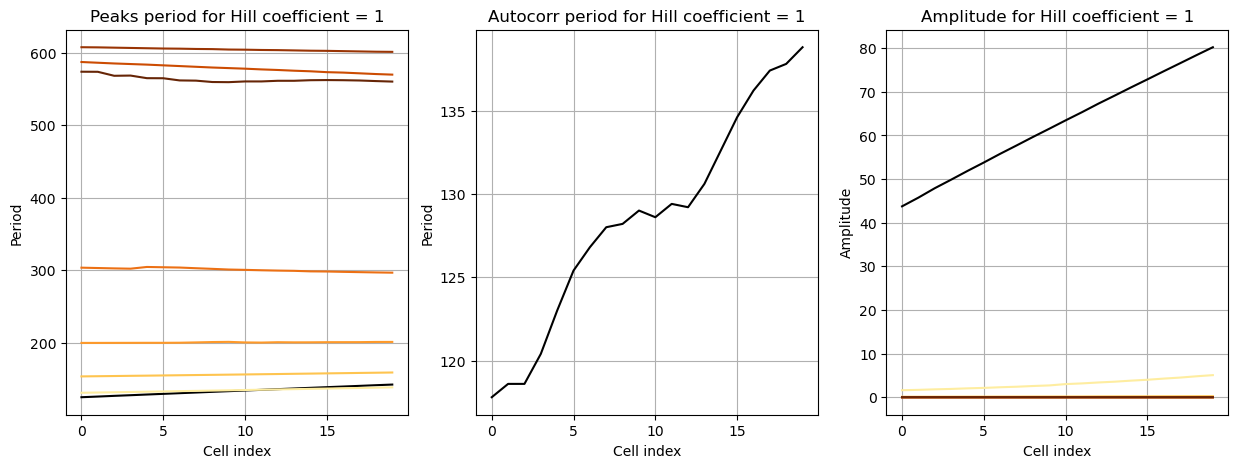

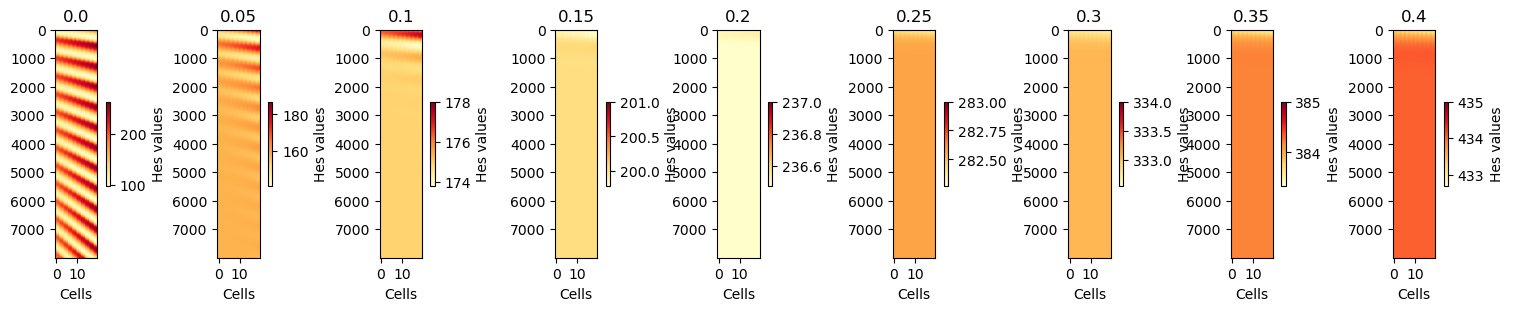

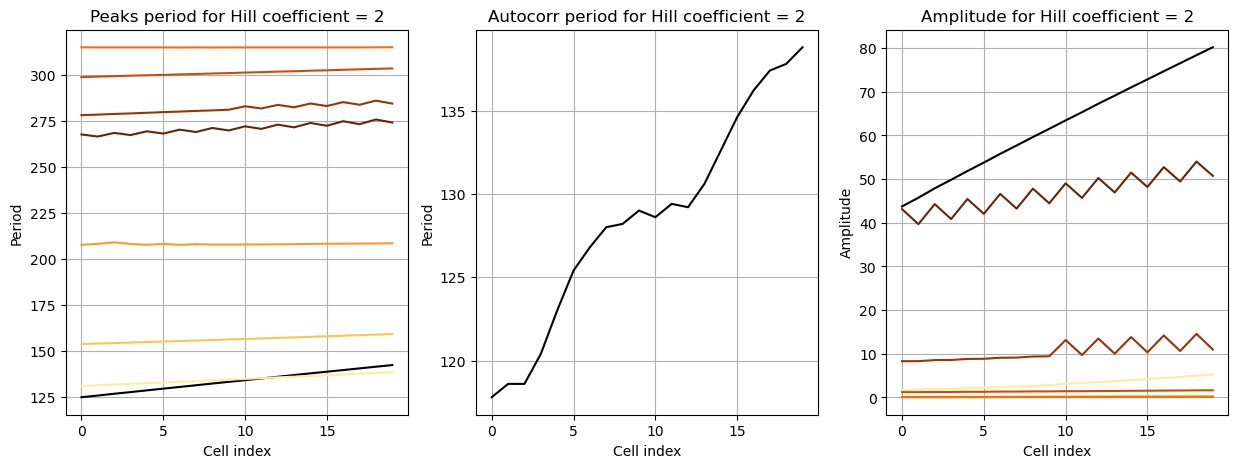

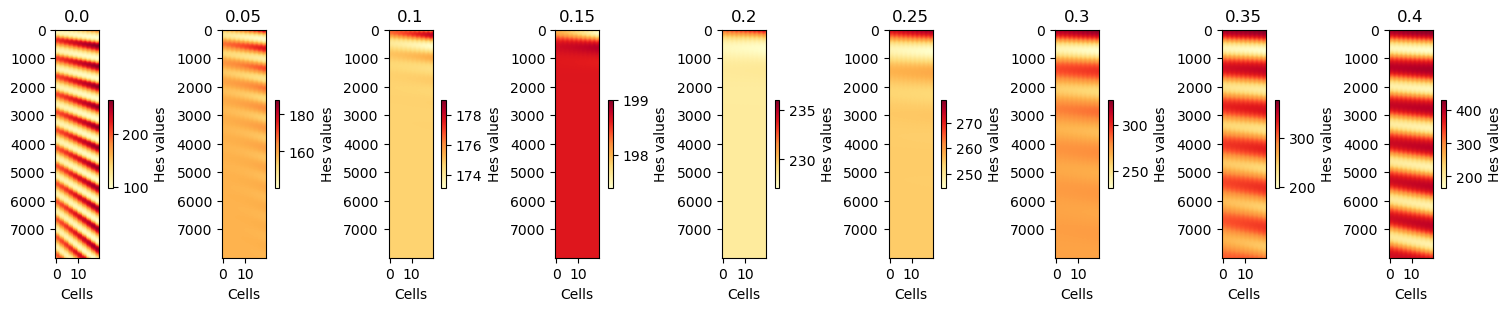

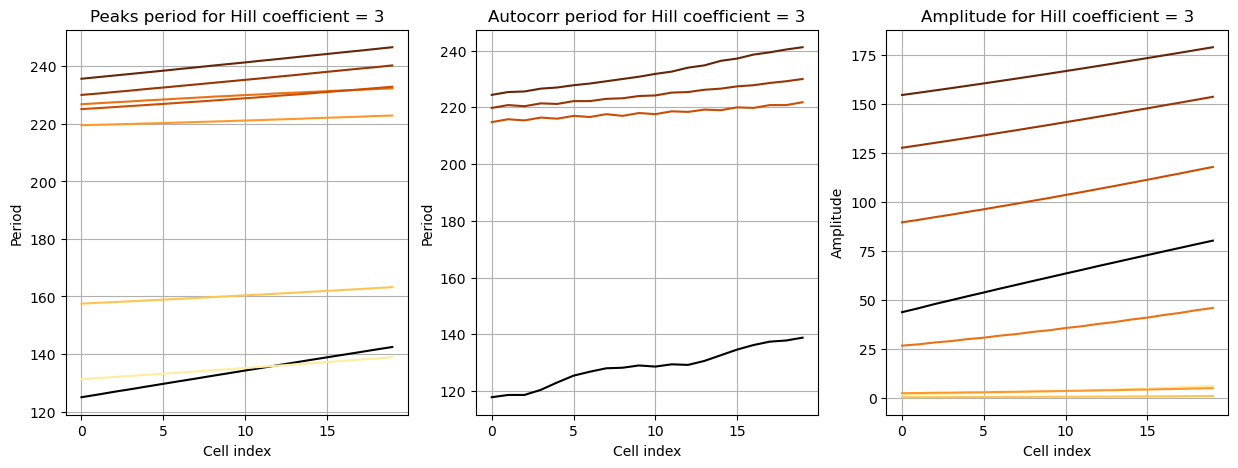

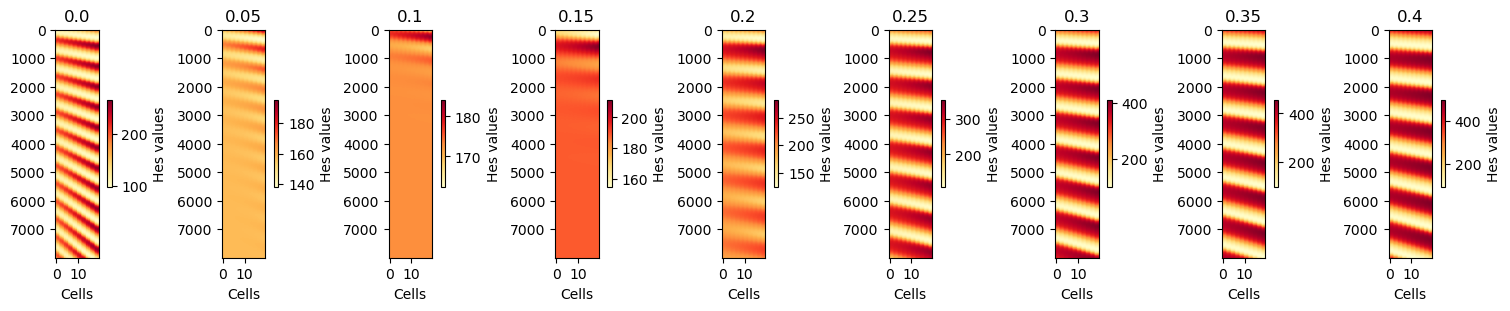

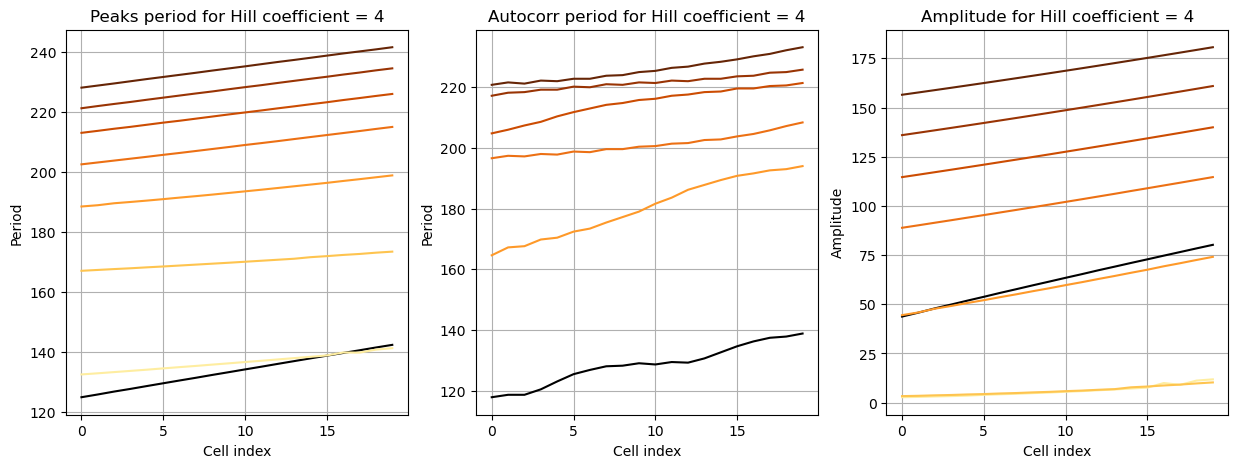

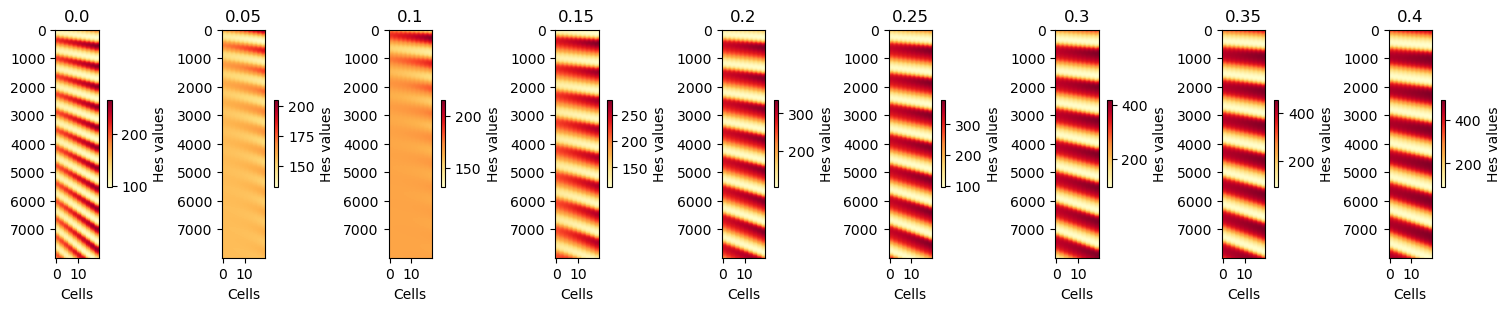

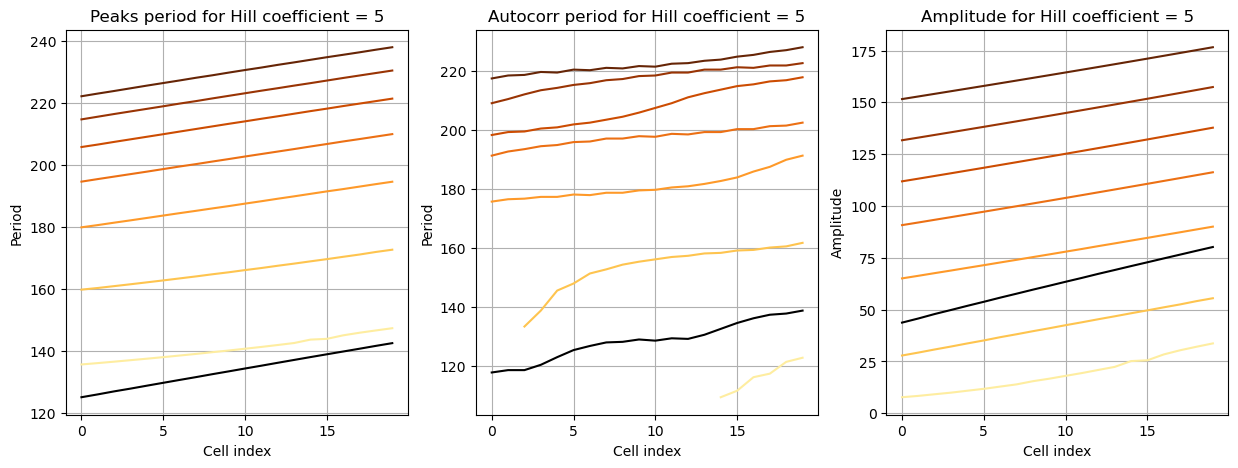

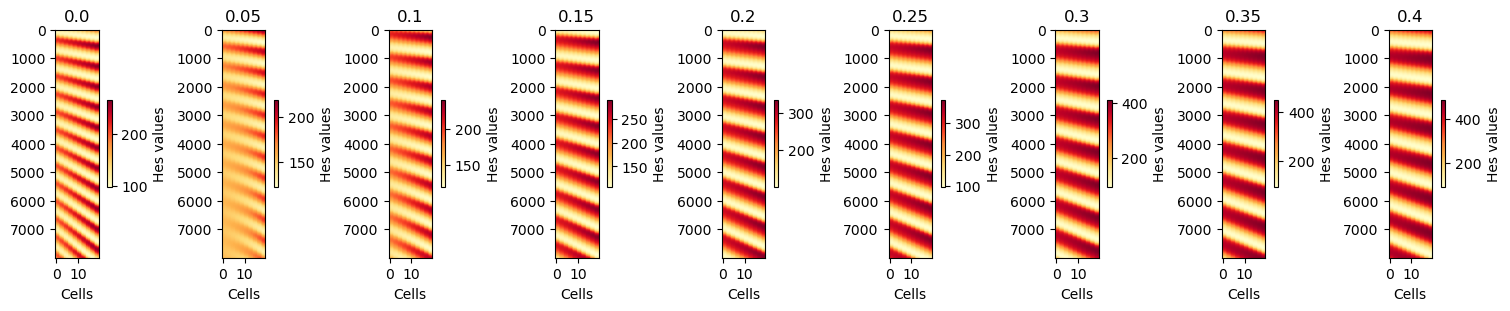

In [ ]:
for i in range(len(coeff_1D)):
    #plot of periods with peaks 
    plt.figure(figsize=(15,5))

    plt.subplot(1, 3, 1)
    plt.title(f'Peaks period for Hill coefficient = {coeff_1D[i]}')
    plt.plot(np.arange(lattice.P), periods_peaks[0,0,:], label = 'no coupling periods', color = 'black')
    plt.xlabel('Cell index')
    plt.ylabel('Period')
    plt.grid()
    
    for j in range(1, len(coupling_strengths_1D)-1):
        plt.plot(np.arange(lattice.P), periods_peaks[i,j,:], color = colors_strengths[j-1], label = f'coeff = {coeff_1D[i]}, coup_strength = {coupling_strengths_1D[j]}')


    # # plot of periods with autocorrelation
    # plt.subplot(1,3,2)
    # plt.title(f'Autocorr period for Hill coefficient = {coeff_1D[i]}')
    # plt.plot(np.arange(lattice.P), periods_autocorr[0,0,:], label = 'no coupling periods', color = 'black')

    # for j in range(1, len(coupling_strengths_1D)-1):
    #     plt.plot(np.arange(lattice.P), periods_autocorr[i,j,:], color = colors_strengths[j-1], label = f'coeff = {coeff_1D[i]}, coup_strength = {coupling_strengths_1D[j]}')

    # plt.xlabel('Cell index')
    # plt.ylabel('Period')
    # plt.grid()
 

    # plot of amplitudes 
    plt.subplot(1,3,3)
    plt.title(f'Amplitude for Hill coefficient = {coeff_1D[i]}')
    plt.plot(np.arange(lattice.P), amplitudes[0,0,:], label = 'no coupling periods', color = 'black')
    for j in range(1, len(coupling_strengths_1D)-1):
        plt.plot(np.arange(lattice.P), amplitudes[i,j,:], color = colors_strengths[j-1], label = f'coeff = {coeff_1D[i]}, coup_strength = {coupling_strengths_1D[j]}')
    plt.xlabel('Cell index')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

    #plot the kymograph for the different coupling strengths
    fig, ax = plt.subplots(1, int(len(coupling_strengths_1D)), figsize=(15,3), constrained_layout=True)

    for j in range(len(coupling_strengths_1D)):

        h_flat = results_1D[i,j,int(time_analysis):,:,0,0].reshape(int(num_tsteps-time_analysis), lattice.P)

        # Plot the first image
        im_j = ax[j].imshow(h_flat, aspect = 'auto',  cmap='YlOrRd', vmin = np.min(h_flat), vmax = np.ceil(np.max(h_flat)))
        #ax[j].set_ylabel('Time')
        ax[j].set_xlabel('Cells')
        ax[j].set_title(str(round(coupling_strengths_1D[j],2)))

        # Add colorbar for the first image
        cbar1 = fig.colorbar(im_j, ax=ax[j], orientation='vertical', fraction=0.1, pad=0.2)
        cbar1.set_label('Hes values')

    plt.show()



## Phase space 

In [19]:
for i in range(lattice.P):
    plt.figure()
    for j in range(lattice.Q):
        q_test = j
        plt.plot(m_h[:,i,q_test], m_d[:,i,q_test],  label = 'for P = ' + str(i))
    plt.xlabel('m_h')
    plt.ylabel('m_d')
    plt.legend()
    plt.show()

NameError: name 'm_h' is not defined

<Figure size 640x480 with 0 Axes>